<a href="https://www.kaggle.com/code/jaksanders/electric-load-forecasting-with-deep-learning?scriptVersionId=146022868" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Short-term residential load forecasting with Deep Learning

* Use London Households SmartMeter Data
* Data evaluation, cleanup and pre-processing for machine learning
* Exploratory data analysis and visualization
* Create a benchmark persistence model to evaluate our deep learning models against
* Build, Train and Evaluate the following algorithms against the benchmark
 - Multi Layer Perceptron, RNN, LSTM, GRU, CNN
* Calculate the financial impact of the most accurate model for a electric distribution network operator


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import IPython
import IPython.display
import glob
import time
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load Data

## Load half-hourly electric usage data
...for ~5k smart meters in London
[SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households)

In [2]:
# load half-hourly electric usage data
# takes about four minutes, need to find somerthing faster like Dask?
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
# Get CSV files list from a folder
path = '/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
start_time = time.time()
df_list = (pd.read_csv(file, parse_dates=["tstp"]) for file in csv_files)
print('%s seconds' % (time.time() - start_time))

# Concatenate all DataFrames
start_time = time.time()
d = pd.concat(df_list, ignore_index=True)
print('%s seconds' % (time.time() - start_time))

0.00010657310485839844 seconds
291.96781945228577 seconds


In [3]:
d.describe()

LCLid                 tstp energy(kWh/hh)
count   167817021            167817021      167817021
unique       5566                40405           9611
top     MAC000147  2012-11-19 00:30:00             0 
freq        39725                 5531        2001094
first         NaN  2011-11-23 09:00:00            NaN
last          NaN  2014-02-28 00:00:00            NaN

## Load hourly weather data

In [4]:
# load hourly weather data
# https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households
weatherData = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv', parse_dates=["time"])

In [5]:
weatherData.describe()

visibility   windBearing   temperature      dewPoint      pressure  \
count  21165.000000  21165.000000  21165.000000  21165.000000  21152.000000   
mean      11.166485    195.685897     10.471486      6.530501   1014.125153   
std        3.099337     90.629453      5.781904      5.041965     11.388337   
min        0.180000      0.000000     -5.640000     -9.980000    975.740000   
25%       10.120000    121.000000      6.470000      2.820000   1007.430000   
50%       12.260000    217.000000      9.930000      6.570000   1014.780000   
75%       13.080000    256.000000     14.310000     10.330000   1022.050000   
max       16.090000    359.000000     32.400000     19.880000   1043.320000   

       apparentTemperature     windSpeed      humidity  
count         21165.000000  21165.000000  21165.000000  
mean              9.230338      3.905215      0.781829  
std               6.940919      2.026854      0.140369  
min              -8.880000      0.040000      0.230000  
25%               3.900000      2.420000      0.700000  
50%               9.360000      3.680000      0.810000  
75%              14.320000      5.070000      0.890000  
max              32.420000     14.800000      1.000000

In [6]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   visibility           21165 non-null  float64       
 1   windBearing          21165 non-null  int64         
 2   temperature          21165 non-null  float64       
 3   time                 21165 non-null  datetime64[ns]
 4   dewPoint             21165 non-null  float64       
 5   pressure             21152 non-null  float64       
 6   apparentTemperature  21165 non-null  float64       
 7   windSpeed            21165 non-null  float64       
 8   precipType           21165 non-null  object        
 9   icon                 21165 non-null  object        
 10  humidity             21165 non-null  float64       
 11  summary              21165 non-null  object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 1.9+ MB


# Data pre-processing and cleaning

## Weather data: convert text attributes to string datatype

In [7]:
weatherData = weatherData.astype({'precipType':'string', 'icon':'string', 'summary':'string'})

In [8]:
from pandas_profiling import ProfileReport

profile = ProfileReport(weatherData, tsmode=True, sortby="time")
profile.to_file('weatherData profile_report.html')
# profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Identify and remove weather records not exactly on the hour

In [9]:
# inspect and remove records not exactly on the hour
offRecs = weatherData.query("time.dt.minute != 0 or time.dt.second != 0")
print('Records not exactly on the half-hour:\n ', offRecs)

Records not exactly on the half-hour:
  Empty DataFrame
Columns: [visibility, windBearing, temperature, time, dewPoint, pressure, apparentTemperature, windSpeed, precipType, icon, humidity, summary]
Index: []


In [10]:
# select weather data features of interest
weatherUpsample = weatherData[['time','temperature', 'dewPoint', 'pressure', 'humidity']].copy()
weatherUpsample = weatherUpsample.sort_values(by=['time'])
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21165 entries, 312 to 20276
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         21165 non-null  datetime64[ns]
 1   temperature  21165 non-null  float64       
 2   dewPoint     21165 non-null  float64       
 3   pressure     21152 non-null  float64       
 4   humidity     21165 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 992.1 KB
None
        temperature      dewPoint      pressure      humidity
count  21165.000000  21165.000000  21152.000000  21165.000000
mean      10.471486      6.530501   1014.125153      0.781829
std        5.781904      5.041965     11.388337      0.140369
min       -5.640000     -9.980000    975.740000      0.230000
25%        6.470000      2.820000   1007.430000      0.700000
50%        9.930000      6.570000   1014.780000      0.810000
75%       14.310000     10.330000   1022.050000

## Upsample weather data to match half-houly sampling rate of load data

In [11]:
# get the index set up to support the resamle operation
weatherUpsample.set_index('time', inplace=True)
weatherUpsample.index.rename('time', inplace=True)

start_time = time.time()
weatherUpsample = weatherUpsample.resample('30Min').mean()

# upsample 
weatherUpsample['temperature'] = weatherUpsample['temperature'].interpolate()
weatherUpsample['dewPoint'] = weatherUpsample['dewPoint'].interpolate()
weatherUpsample['pressure'] = weatherUpsample['pressure'].interpolate()
weatherUpsample['humidity'] = weatherUpsample['humidity'].interpolate()

print('%s seconds' % (time.time() - start_time))

weatherUpsample = weatherUpsample.reset_index(names='DateTime')
print(weatherUpsample.info())
print(weatherUpsample.describe())
print(weatherUpsample)

0.0300905704498291 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42333 entries, 0 to 42332
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DateTime     42333 non-null  datetime64[ns]
 1   temperature  42333 non-null  float64       
 2   dewPoint     42333 non-null  float64       
 3   pressure     42333 non-null  float64       
 4   humidity     42333 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.6 MB
None
        temperature      dewPoint      pressure     humidity
count  42333.000000  42333.000000  42333.000000  42333.00000
mean      10.471414      6.530646   1014.125954      0.78184
std        5.775688      5.037766     11.384204      0.13968
min       -5.640000     -9.980000    975.740000      0.23000
25%        6.475000      2.830000   1007.440000      0.70000
50%        9.935000      6.575000   1014.780000      0.81000
75%       14.320000     10.3250

In [12]:
# save weather data so we can don't have to do pre-processing again
weatherUpsample.to_csv('/kaggle/working/WeatherDataFinal.csv',index=False)

In [13]:
# load pre-processed weather data
weatherUpsample = pd.read_csv('/kaggle/working/WeatherDataFinal.csv', parse_dates=["DateTime"])
weatherUpsample

DateTime  temperature  dewPoint  pressure  humidity
0     2011-11-01 00:00:00       13.490    11.480  1008.140     0.880
1     2011-11-01 00:30:00       13.110    11.530  1008.010     0.905
2     2011-11-01 01:00:00       12.730    11.580  1007.880     0.930
3     2011-11-01 01:30:00       13.190    11.860  1007.485     0.920
4     2011-11-01 02:00:00       13.650    12.140  1007.090     0.910
...                   ...          ...       ...       ...       ...
42328 2014-03-31 20:00:00       13.620     7.910  1011.980     0.680
42329 2014-03-31 20:30:00       13.325     7.935  1011.975     0.695
42330 2014-03-31 21:00:00       13.030     7.960  1011.970     0.710
42331 2014-03-31 21:30:00       12.770     7.965  1011.900     0.725
42332 2014-03-31 22:00:00       12.510     7.970  1011.830     0.740

[42333 rows x 5 columns]

In [14]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   LCLid           object        
 1   tstp            datetime64[ns]
 2   energy(kWh/hh)  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.8+ GB


In [15]:
# utility function to nicely format variable names and memory they are consuming
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

## Convert smart meter usage datatype to float

In [16]:
# ~1 minute
start_time = time.time()
d.iloc[:, 2] = pd.to_numeric(d.iloc[:, 2], errors='coerce')
print('%s seconds' % (time.time() - start_time))

# rename usage column for easier reference
d.rename(columns={d.columns[2]: 'KWHperHH'}, inplace=True)
d.info()

29.950234413146973 seconds
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


In [17]:
# set timestamp as the index
start_time = time.time()
d.set_index('tstp')
print('%s seconds' % (time.time() - start_time))

0.7498378753662109 seconds


## Identify and handle duplicates in the smart meter data

In [18]:
# about 1.5 minutes
start_time = time.time()
dupes = d[d.duplicated()]
print('dupes', dupes)
print('dupes.index', dupes.index)
d.drop(index=dupes.index, inplace=True)
print('%s seconds' % (time.time() - start_time))

dupes Empty DataFrame
Columns: [LCLid, tstp, KWHperHH]
Index: []
dupes.index Int64Index([], dtype='int64')
45.30626106262207 seconds


In [19]:
# set index for the usage data to the timestamp column.  Is this necessary?  Can't remember why
start_time = time.time()
d.set_index('tstp')
d.info()
print('%s seconds' % (time.time() - start_time))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167817021 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB
0.6426575183868408 seconds


In [20]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 12.8 GiB
                   weatherData:  5.5 MiB
                             _:  1.6 MiB
               weatherUpsample:  1.6 MiB
                           _13:  1.6 MiB
                           ___:  1.3 KiB
                            _3:  1.3 KiB
                 ProfileReport:  1.2 KiB
                     csv_files:  1.1 KiB
                            __: 1011.0 B


# Visualize smart meter dataset to analyze for quality, completenes and othe insights

## grab a random sample of 2% of meters for visualization and analysis

In [21]:
rng = np.random.default_rng(randomState)
# random_state = np.random.RandomState(randomState)
sampleMeters = rng.choice(d.LCLid.unique(), size=int(len(d.LCLid.unique())*0.02), replace=False)
print('sampleMeters:\n', sampleMeters)
sample = d[d['LCLid'].isin(sampleMeters)]
print('sample:\n', sample)
print(sample.describe())
# print(sample.info())

sampleMeters:
 ['MAC003787' 'MAC004997' 'MAC000079' 'MAC001558' 'MAC001656' 'MAC001938'
 'MAC003313' 'MAC001152' 'MAC002826' 'MAC000272' 'MAC000133' 'MAC001726'
 'MAC004462' 'MAC003604' 'MAC001933' 'MAC003085' 'MAC004775' 'MAC005467'
 'MAC002659' 'MAC005353' 'MAC003411' 'MAC005264' 'MAC000875' 'MAC001330'
 'MAC002750' 'MAC003007' 'MAC003705' 'MAC003049' 'MAC003468' 'MAC004190'
 'MAC002703' 'MAC000477' 'MAC000020' 'MAC003603' 'MAC001982' 'MAC003471'
 'MAC000878' 'MAC004084' 'MAC001267' 'MAC004947' 'MAC001665' 'MAC005543'
 'MAC001762' 'MAC003512' 'MAC000071' 'MAC000089' 'MAC005269' 'MAC004873'
 'MAC000118' 'MAC001493' 'MAC003876' 'MAC005095' 'MAC002583' 'MAC005132'
 'MAC004659' 'MAC004419' 'MAC002866' 'MAC002854' 'MAC001995' 'MAC004157'
 'MAC002860' 'MAC004271' 'MAC000407' 'MAC002805' 'MAC004927' 'MAC001184'
 'MAC001159' 'MAC002448' 'MAC003486' 'MAC001054' 'MAC003291' 'MAC005448'
 'MAC002654' 'MAC003222' 'MAC004803' 'MAC004460' 'MAC003087' 'MAC000214'
 'MAC003040' 'MAC000183' 'MAC000653'

In [22]:
sample.to_csv('/kaggle/working/sampleMeters.csv',index=False)

In [23]:
sample = pd.read_csv('/kaggle/working/sampleMeters.csv', parse_dates=["tstp"])
sample

LCLid                tstp  KWHperHH
0        MAC001330 2012-05-17 11:00:00     0.157
1        MAC001330 2012-05-17 11:30:00     0.192
2        MAC001330 2012-05-17 12:00:00     0.675
3        MAC001330 2012-05-17 12:30:00     0.418
4        MAC001330 2012-05-17 13:00:00     1.446
...            ...                 ...       ...
3410959  MAC005448 2014-02-27 22:00:00     0.144
3410960  MAC005448 2014-02-27 22:30:00     0.086
3410961  MAC005448 2014-02-27 23:00:00     0.053
3410962  MAC005448 2014-02-27 23:30:00     0.058
3410963  MAC005448 2014-02-28 00:00:00     0.048

[3410964 rows x 3 columns]

## Heatmap to visualize meter read coverage and completeness

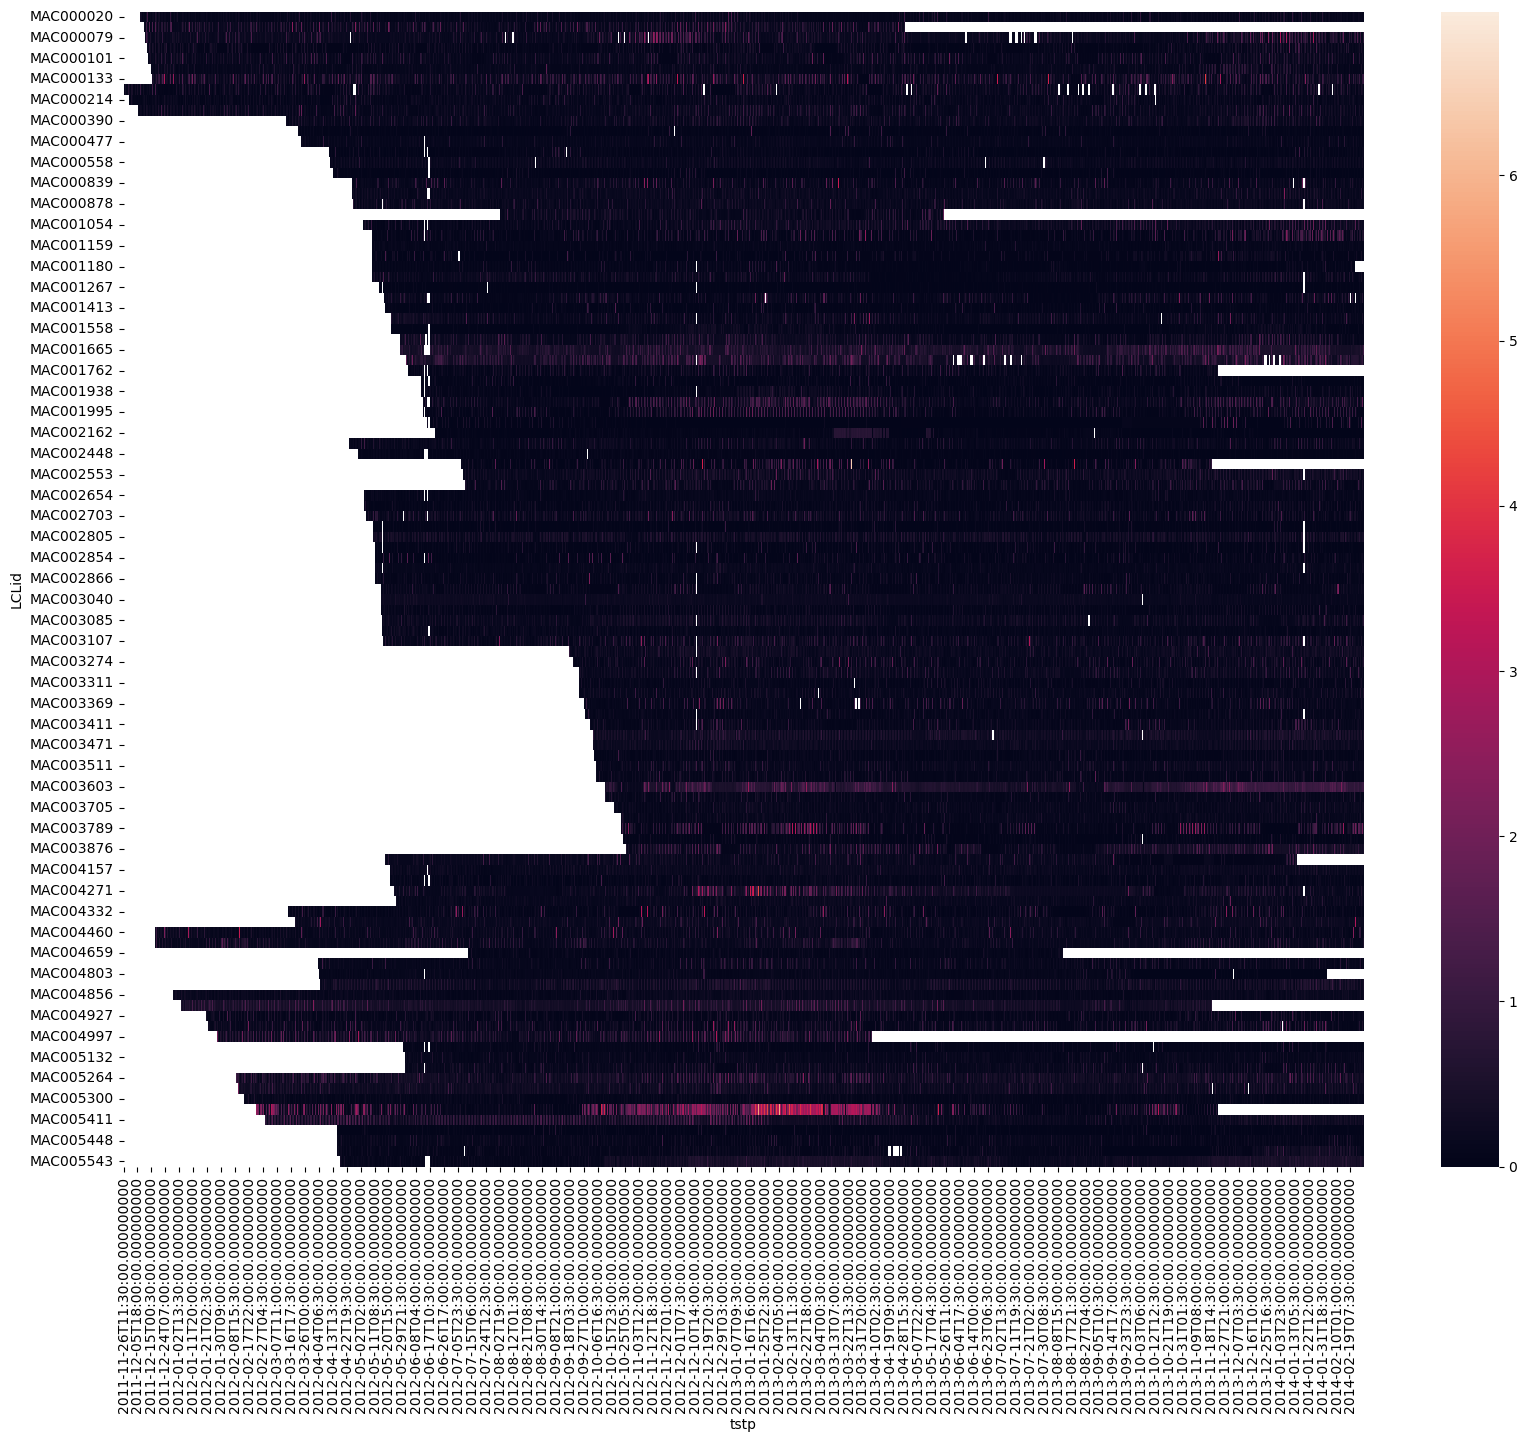

In [24]:
# visualize meter read coverage and completeness
# using a random sample of 2% of meters
plt.subplots(figsize=(20,15))
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
sns.heatmap(pivot_table)
plt.savefig('meter data heatmap.png', format='png')

Observations from Heatmap...
* several houses start producing load part-way through the period
    - eg MAC004221, MAC004248
    
    
* several houses stop producing part-way through the period
    - eg MAC004226, MAC004257
    

* most houses have at least one "gap" in their data (visible as white lines)


* several houses stand out as having significantly higher average load than others
    - eg MAC004225, MAC004249

## identify and remove smart meter readings not exactly on the half-hour

In [25]:
# identify and remove records not exactly on the half-hour
start_time = time.time()

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
# aggLoad["DateTime"].dt.hour > 30
print('Records not exactly on the half-hour:\n ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
d.drop(offRecs.index, inplace=True)

print('%s seconds' % (time.time() - start_time))

offRecs = d.query("tstp.dt.minute not in (0,30) or tstp.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:
                 LCLid                tstp  KWHperHH
18051      MAC000047 2012-12-18 15:13:44       NaN
52485      MAC000362 2012-12-18 15:15:14       NaN
86881      MAC000385 2012-12-18 15:15:16       NaN
120772     MAC000486 2012-12-18 15:15:42       NaN
138889     MAC000507 2012-12-18 15:15:45       NaN
...              ...                 ...       ...
167658239  MAC005035 2012-12-18 15:14:33       NaN
167694593  MAC005048 2012-12-18 15:14:35       NaN
167730712  MAC005229 2012-12-18 15:14:41       NaN
167763454  MAC005448 2012-12-18 15:16:23       NaN
167796074  MAC005508 2012-12-18 15:16:29       NaN

[5560 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5560 entries, 18051 to 167796074
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   LCLid     5560 non-null   object        
 1   tstp      5560 non-null   datetime64[ns]
 2   KWHperHH  0 non-nul

In [26]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167811461 entries, 0 to 167817020
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.0+ GB


In [27]:
# check what is gobbling RAM
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             d: 14.1 GiB
                             _: 266.7 MiB
                        sample: 266.7 MiB
                           _23: 266.7 MiB
                   pivot_table: 33.5 MiB
                   weatherData:  5.5 MiB
                            __:  1.6 MiB
               weatherUpsample:  1.6 MiB
                           _13:  1.6 MiB
                            _3:  1.3 KiB


## Fill gaps in the smart meter data using interpolation

Our heatmap above shows lots of gaps (small white vertical lines), and we'll fill those gaps using interpolation

### First step of filling these gaps is to create NaN records where records are missing

Then we can fill these gas with interpolation

In [28]:
# First step of interpolation is to create NaN records where records are missing
# about 2 minutes
d.sort_values(by=['tstp'], inplace=True)
d.set_index('tstp', inplace=True)
d.index.rename('tstp', inplace=True)

start_time = time.time()
# resample to create NaN records where records are missing
d = d.groupby('LCLid')\
                .resample('30Min')\
                .mean()

# fill the gaps with interpolation
d['KWHperHH'] = d['KWHperHH'].interpolate()
d.reset_index(inplace=True)

print('%s seconds' % (time.time() - start_time))

65.34256267547607 seconds


## Check the meter data heatmap to see if gaps have been filled

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168268119 entries, 0 to 168268118
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   LCLid     object        
 1   tstp      datetime64[ns]
 2   KWHperHH  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.8+ GB


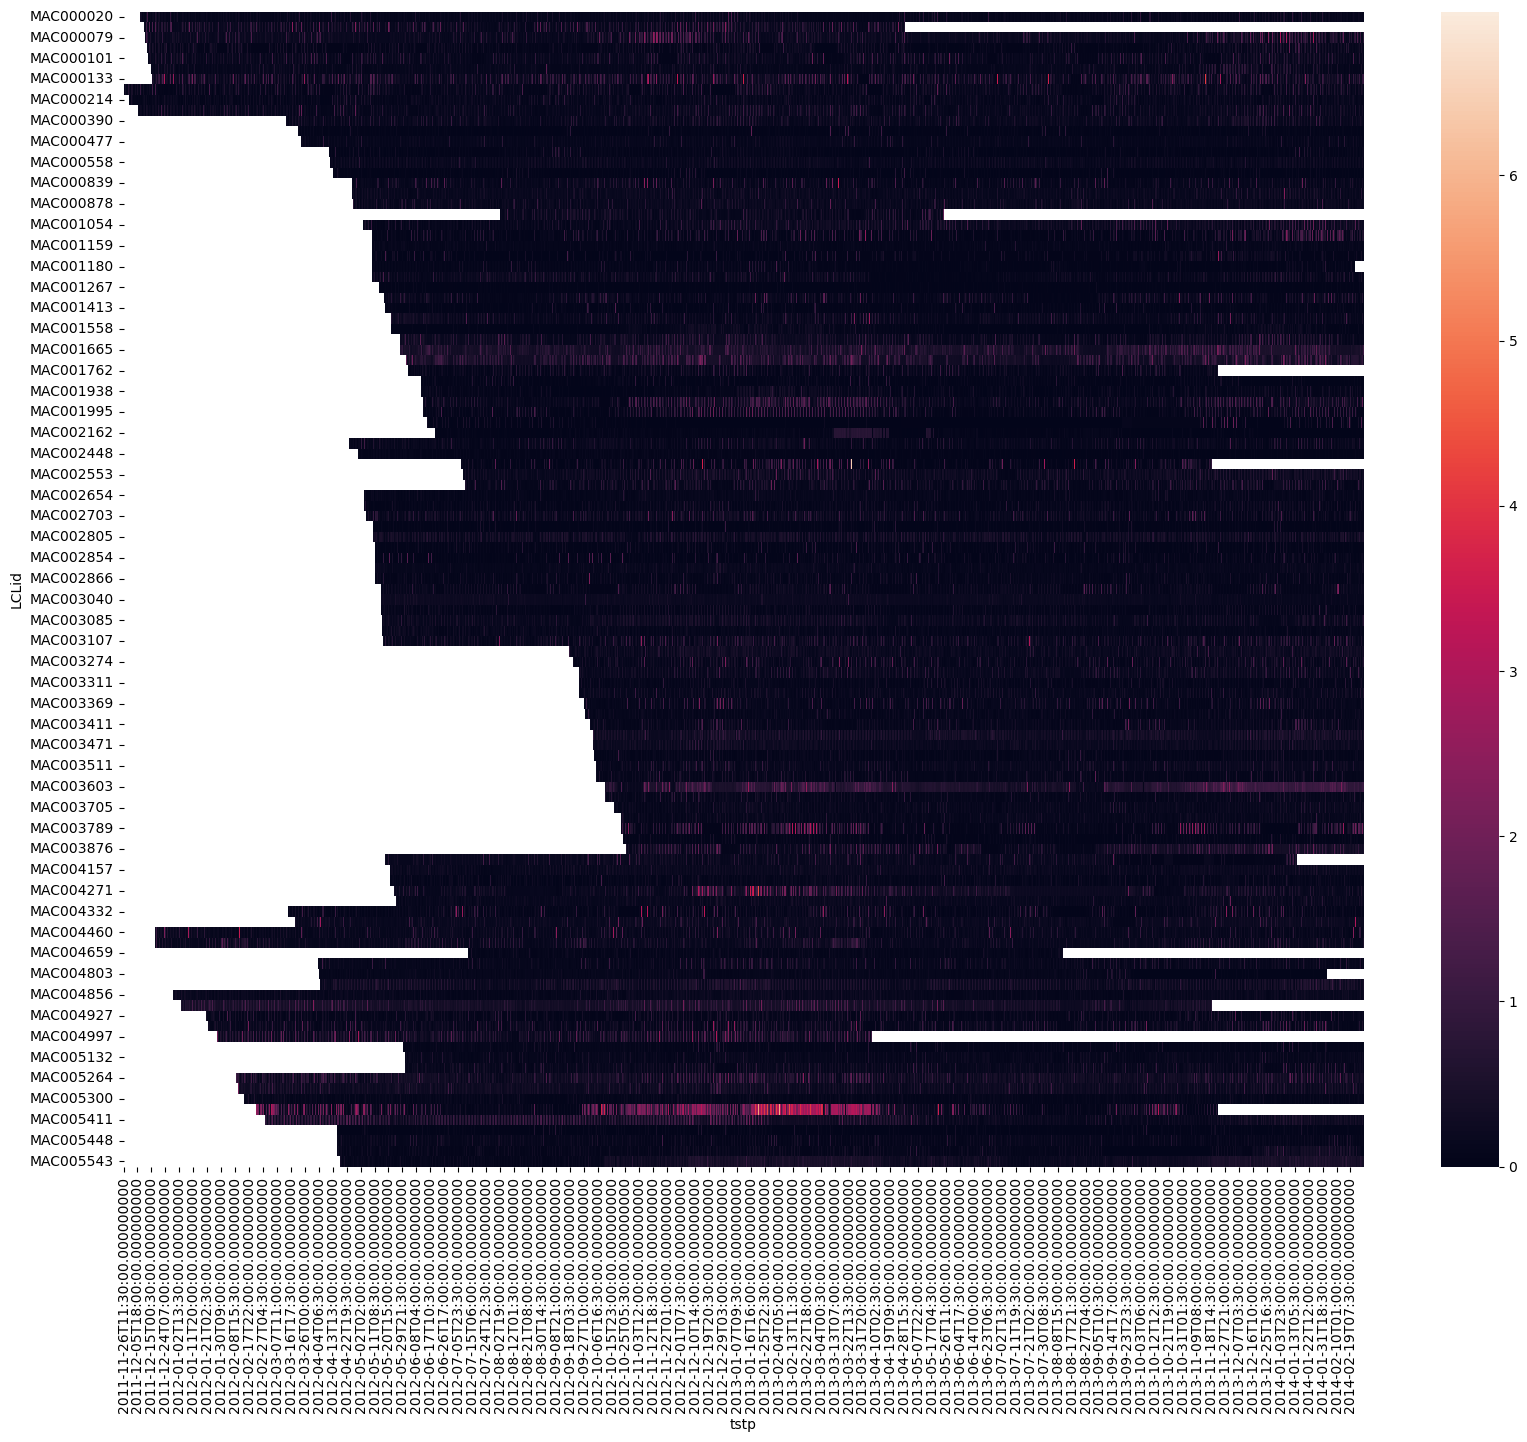

In [29]:
# visualize after interpolating missing values
d.info()
sample = d[d['LCLid'].isin(sampleMeters)]
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='KWHperHH')
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap gaps filled.png', format='png')

## Visualize zeros in the dataset using heatmap

I'm always curious to understand zeros in a dataset, and whether they are legitimate zero values, or indicate a data quality problem.

4.017910003662109 seconds


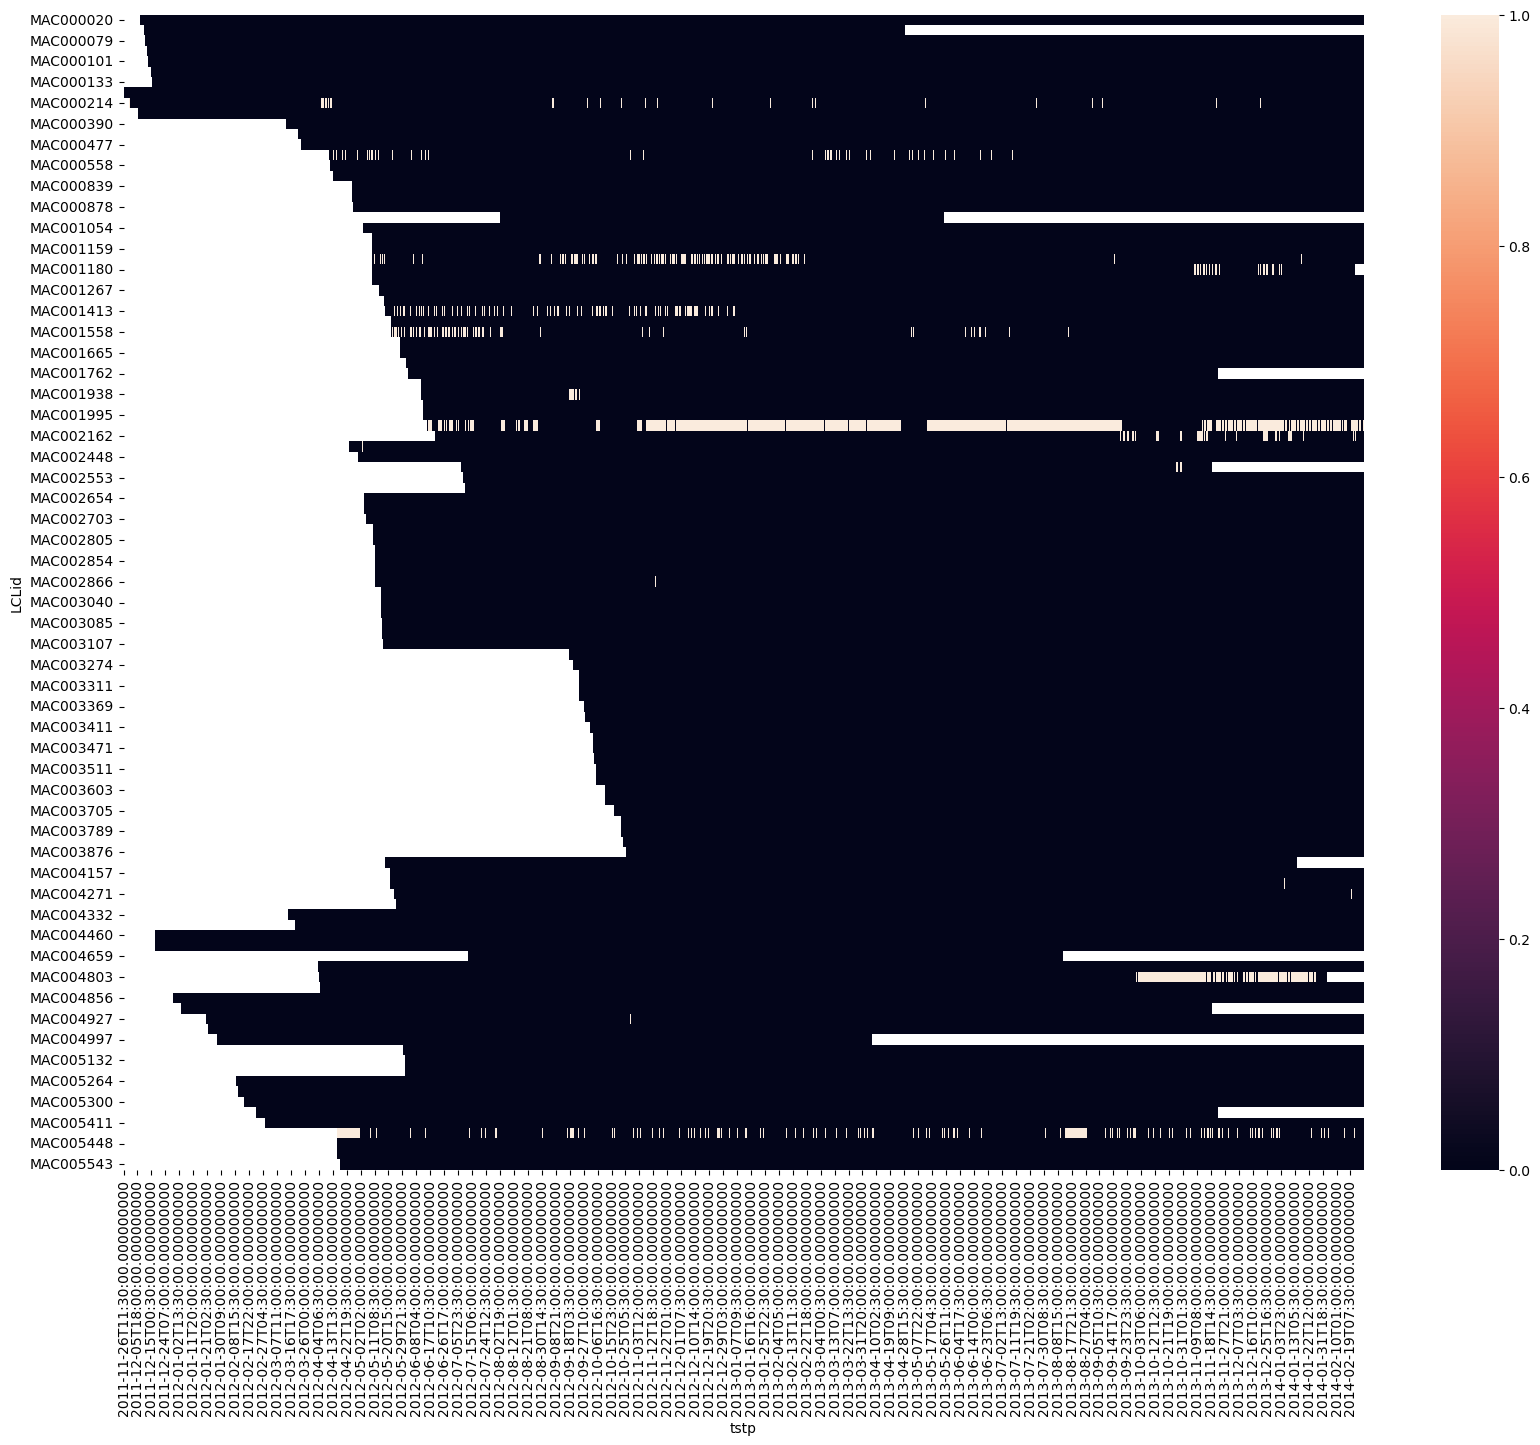

In [30]:
# visualize zeros in the dataset
start_time = time.time()
sample = d[d['LCLid'].isin(sampleMeters)]
sample['ZeroKWHperHH'] = sample['KWHperHH'] == 0
pivot_table = pd.pivot_table(sample, columns='tstp', index='LCLid', values='ZeroKWHperHH')
print('%s seconds' % (time.time() - start_time))
plt.subplots(figsize=(20,15))

sns.heatmap(pivot_table)
plt.savefig('meter data heatmap zeros.png', format='png')

In [31]:
# take a snapshot of data
# takes about 11 minutes
start_time = time.time()
d.to_csv('/kaggle/working/MeterDataFinal.csv',index=False)
print('%s seconds' % (time.time() - start_time))

430.5976765155792 seconds


### Obervation

There are a handful of households that account all the zero value meter reads: MAC004233, MAC004226, MAC004267

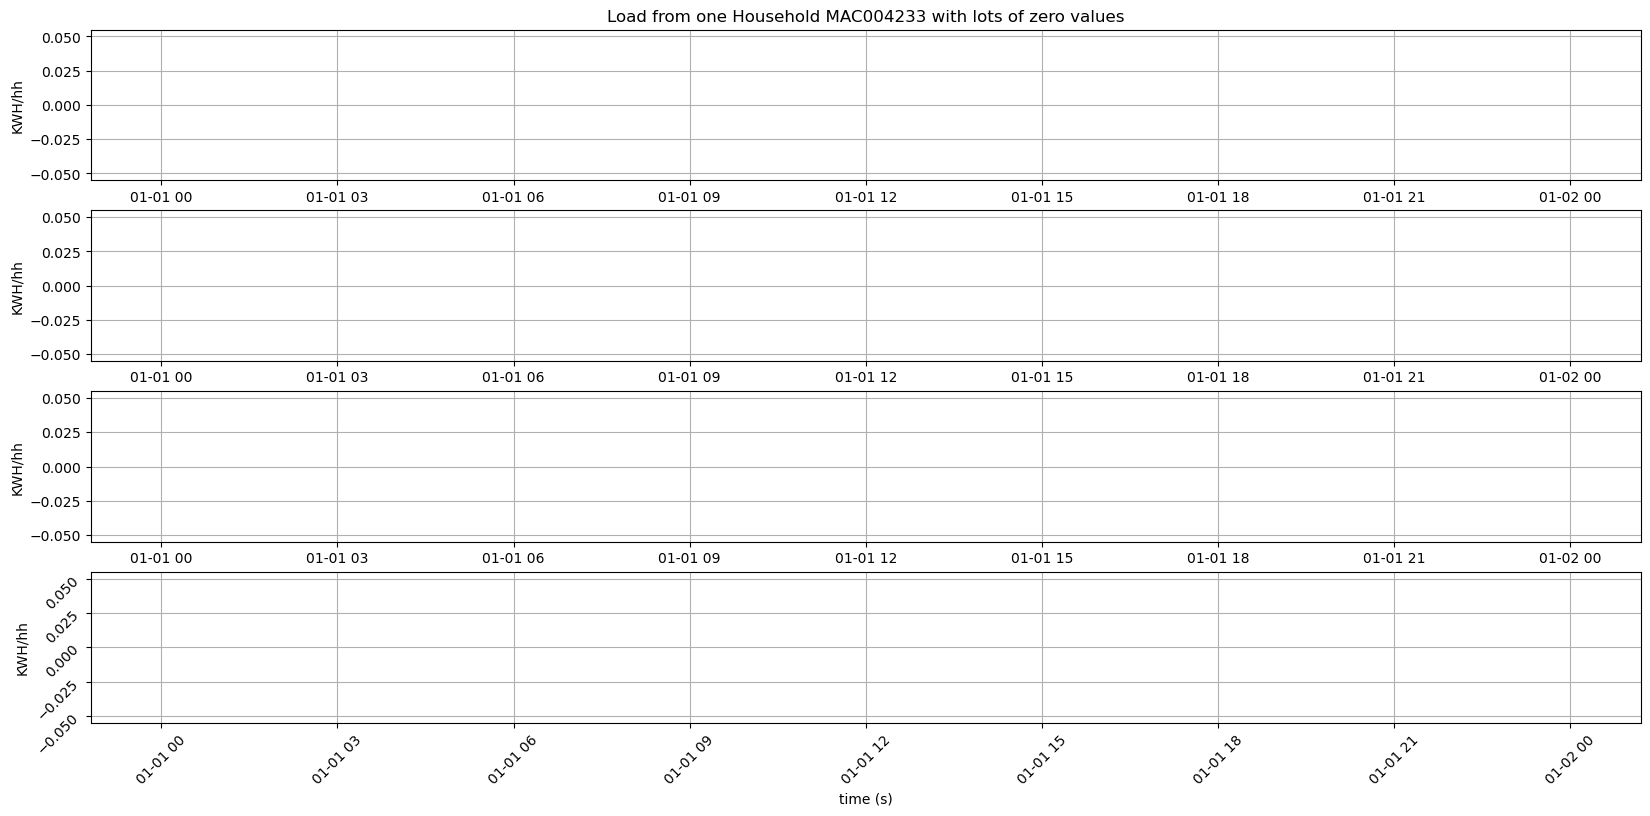

In [32]:
# investigate the meters with zero reads
MAC005127 = sample.query("LCLid == 'MAC005127'")

fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC005127.tstp, MAC005127.KWHperHH)
ax[0].plot(MAC005127.tstp, MAC005127.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC004233 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC005127.tstp[11000:15000], MAC005127.KWHperHH[11000:15000])
ax[1].plot(MAC005127.tstp[11000:15000], MAC005127.ZeroKWHperHH[11000:15000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC005127.tstp[13000:13500], MAC005127.KWHperHH[13000:13500])
ax[2].plot(MAC005127.tstp[13000:13500], MAC005127.ZeroKWHperHH[13000:13500])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC005127.tstp[25000:25500], MAC005127.KWHperHH[25000:25500])
ax[3].plot(MAC005127.tstp[25000:25500], MAC005127.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC005127.png")
plt.show()

### Observation:
The zeros for MAC004233 seem legit - leaving them in

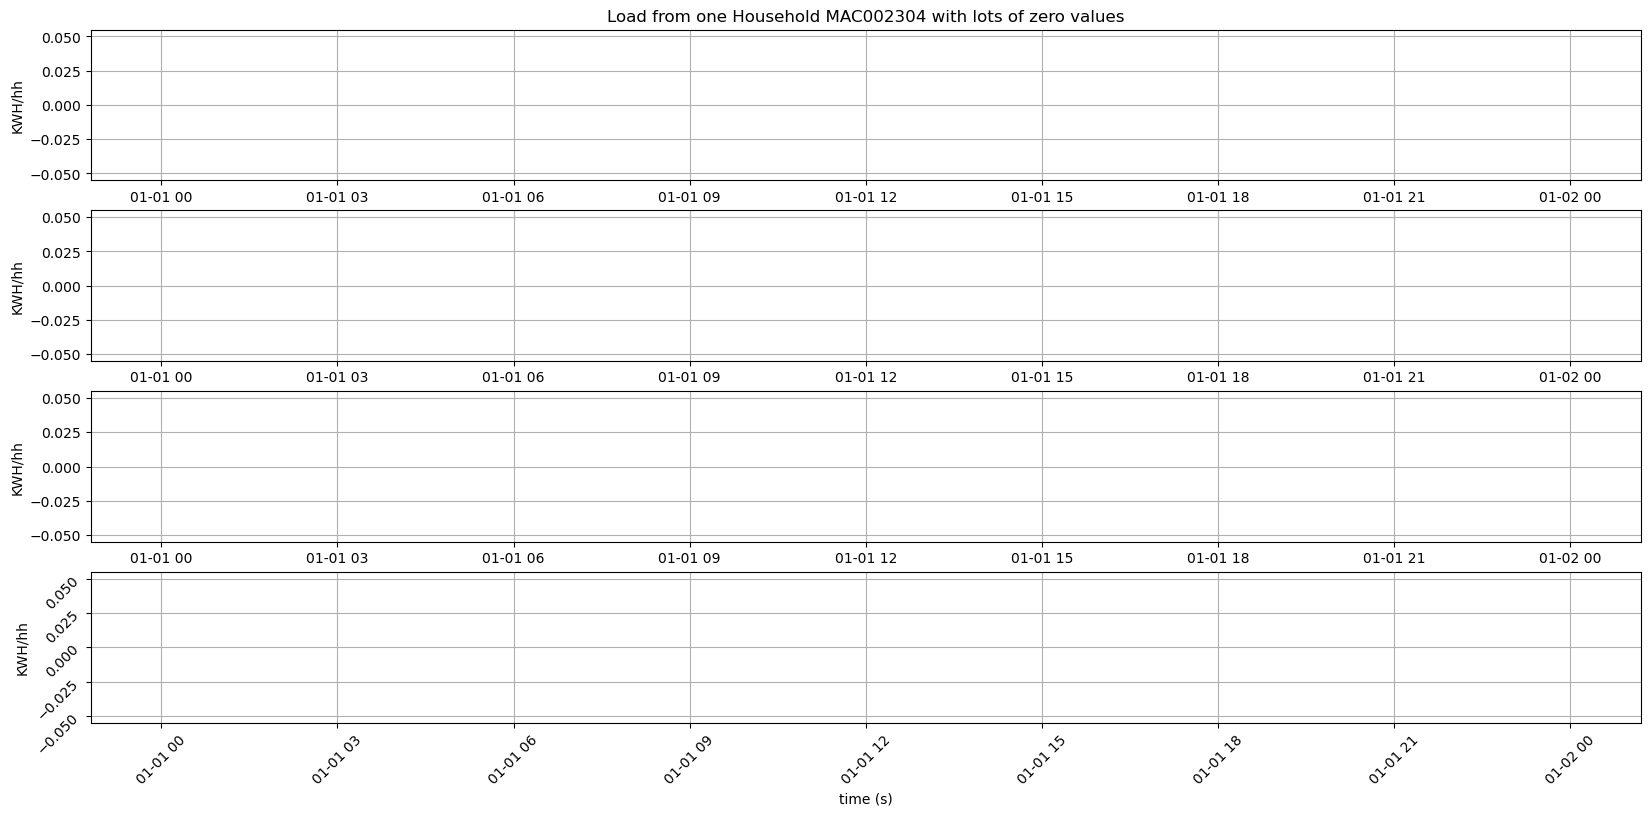

In [33]:
# investigate the meters with zero reads
MAC002304 = sample.query("LCLid == 'MAC002304'")
fig, ax = plt.subplots(4,figsize=(20,9))

# plot whole ~2 years
ax[0].plot(MAC002304.tstp, MAC002304.KWHperHH)
ax[0].plot(MAC002304.tstp, MAC002304.ZeroKWHperHH)
ax[0].set(ylabel='KWH/hh',
       title='Load from one Household MAC002304 with lots of zero values')
plt.tick_params(rotation=45)
ax[0].grid()

# zoom in
ax[1].plot(MAC002304.tstp[17000:21000], MAC002304.KWHperHH[17000:21000])
ax[1].plot(MAC002304.tstp[17000:21000], MAC002304.ZeroKWHperHH[17000:21000])
ax[1].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[1].grid()

# zoom in more...
ax[2].plot(MAC002304.tstp[19300:19800], MAC002304.KWHperHH[19300:19800])
ax[2].plot(MAC002304.tstp[19300:19800], MAC002304.ZeroKWHperHH[19300:19800])
ax[2].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[2].grid()

# zoom in to a different part of the series...
ax[3].plot(MAC002304.tstp[25000:25500], MAC002304.KWHperHH[25000:25500])
ax[3].plot(MAC002304.tstp[25000:25500], MAC002304.ZeroKWHperHH[25000:25500])
ax[3].set(xlabel='time (s)', ylabel='KWH/hh')
plt.tick_params(rotation=45)
ax[3].grid()

fig.savefig("MAC002304.png")
plt.show()

### Observation

The zeros for MAC004233 seem legit - leaving them in


In [34]:
# visualize and handle outliers

# minumum and maximum timestamp for each house
print(d.groupby('LCLid').max().sort_values('tstp'))
print(d.groupby('LCLid').min().sort_values('tstp'))
print(d.groupby('LCLid').count().sort_values('tstp'))

print(d.groupby('LCLid').agg(['min', 'max', 'count']))


                         tstp  KWHperHH
LCLid                                  
MAC001300 2012-05-22 23:30:00     1.697
MAC001278 2012-05-24 23:30:00     1.168
MAC005565 2012-06-21 07:00:00     1.022
MAC001957 2012-06-26 00:00:00     0.940
MAC002110 2012-06-26 10:00:00     0.919
...                       ...       ...
MAC001976 2014-02-28 00:00:00     2.751
MAC001975 2014-02-28 00:00:00     2.096
MAC001974 2014-02-28 00:00:00     2.623
MAC001993 2014-02-28 00:00:00     1.347
MAC005567 2014-02-28 00:00:00     1.528

[5561 rows x 2 columns]
                         tstp  KWHperHH
LCLid                                  
MAC000145 2011-11-23 09:00:00     0.024
MAC000146 2011-11-23 09:00:00     0.031
MAC000147 2011-11-23 10:00:00     0.008
MAC000148 2011-11-23 10:00:00     0.000
MAC000149 2011-11-23 10:00:00     0.000
...                       ...       ...
MAC003155 2013-07-04 00:30:00     0.047
MAC005510 2013-09-21 00:30:00     0.000
MAC001477 2013-10-23 00:30:00     0.018
MAC001653 2013-

In [35]:
# which house has the highest peak load?

# which house has the highest total aggregate load?

# how variable / predictable is the timing of the peak load

# how accurate is the next 24 hours forecast profile overall?

# how accurate is the peak load forecast in next 24 hours?

# normalize and standardize


In [36]:
# extract one smartmeter for plotting
sample = d.query("LCLid == 'MAC004233'")
sample

LCLid                tstp  KWHperHH
124559531  MAC004233 2012-05-23 12:00:00     0.009
124559532  MAC004233 2012-05-23 12:30:00     0.016
124559533  MAC004233 2012-05-23 13:00:00     0.691
124559534  MAC004233 2012-05-23 13:30:00     0.154
124559535  MAC004233 2012-05-23 14:00:00     0.024
...              ...                 ...       ...
124590511  MAC004233 2014-02-27 22:00:00     0.116
124590512  MAC004233 2014-02-27 22:30:00     0.123
124590513  MAC004233 2014-02-27 23:00:00     0.036
124590514  MAC004233 2014-02-27 23:30:00     0.037
124590515  MAC004233 2014-02-28 00:00:00     0.020

[30985 rows x 3 columns]

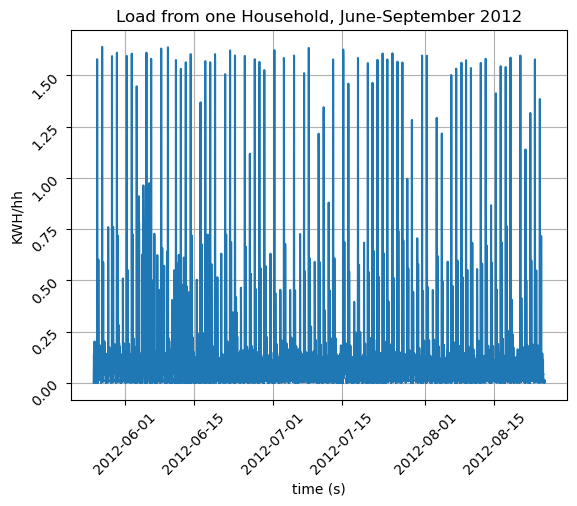

In [37]:
# Visualize load profile for one household meter
fig, ax = plt.subplots()
ax.plot(sample.iloc[100:4500,1], sample.iloc[100:4500,2])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Load from one Household, June-September 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Load from one Household, June-September 2012.png")
plt.show()

In [38]:
# set index for the sample
sample.set_index('tstp')

LCLid  KWHperHH
tstp                                    
2012-05-23 12:00:00  MAC004233     0.009
2012-05-23 12:30:00  MAC004233     0.016
2012-05-23 13:00:00  MAC004233     0.691
2012-05-23 13:30:00  MAC004233     0.154
2012-05-23 14:00:00  MAC004233     0.024
...                        ...       ...
2014-02-27 22:00:00  MAC004233     0.116
2014-02-27 22:30:00  MAC004233     0.123
2014-02-27 23:00:00  MAC004233     0.036
2014-02-27 23:30:00  MAC004233     0.037
2014-02-28 00:00:00  MAC004233     0.020

[30985 rows x 2 columns]

# EDA: Visualize daily average load for each meter and all meters...

18.05676794052124 seconds
20.978285551071167 seconds


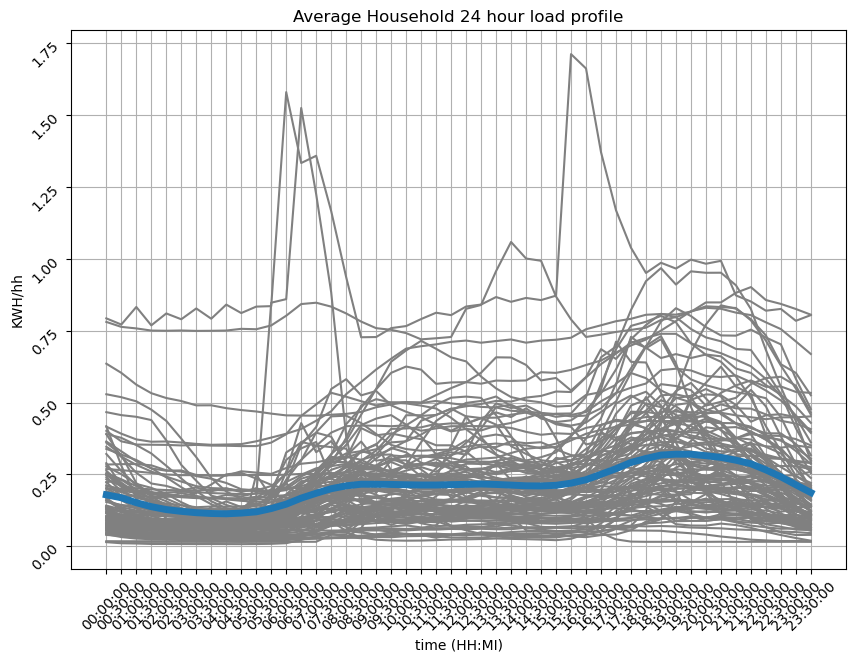

In [39]:
# calculate average daily load profile for all meters...
# abut 1.5 minutes

start_time = time.time()
avgLoadProfile = pd.DataFrame(d.groupby([d['tstp'].dt.hour, d['tstp'].dt.minute]).KWHperHH.mean())
avgLoadProfile = avgLoadProfile.reset_index(names=['hour', 'minute'])
avgLoadProfile['labels'] = pd.to_datetime(avgLoadProfile['hour'].astype(str) + ':' + avgLoadProfile['minute'].astype(str), format='%H:%M').dt.time
print('%s seconds' % (time.time() - start_time))

# print(avgLoadProfile.info())
# print(avgLoadProfile)

fig, ax = plt.subplots(figsize=(10,7))

ax.set_xticks(avgLoadProfile.index, avgLoadProfile.labels)

ax.set(xlabel='time (HH:MI)', ylabel='KWH/hh',
       title='Average Household 24 hour load profile')

# calculate average daily load for each meter...
start_time = time.time()
avgLoadProfileEachMeter = pd.DataFrame(d.groupby(['LCLid', d['tstp'].dt.hour, d['tstp'].dt.minute]).agg({'KWHperHH': 'mean'}))
avgLoadProfileEachMeter = avgLoadProfileEachMeter.reset_index(names=['LCLid', 'hour', 'minute'])
print('%s seconds' % (time.time() - start_time))
# print(avgLoadProfileEachMeter.info())
# print(avgLoadProfileEachMeter)

# plot every sample meter
for meter in sampleMeters:
    # print(meter)
    ax.plot(avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].index % 48, 
            avgLoadProfileEachMeter.loc[avgLoadProfileEachMeter['LCLid'] == meter].KWHperHH,
           color='grey')

# plot the average
ax.plot(avgLoadProfile.index, avgLoadProfile.KWHperHH, linewidth=5)

plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Avg 24hr Load Profile every meter.png")
plt.show()

## Create aggregate features: aggregate load (our target) and count of meters

In [40]:
# Calculate the sum of all loads and count of smart meters for each timestamp
start_time = time.time()
aggLoad = pd.DataFrame(d.groupby('tstp')['KWHperHH'].agg({'count', 'sum'}))
aggLoad.reset_index(inplace=True)
aggLoad.columns = ['tstp', 'AggregateLoad', 'numMeters']
print('%s seconds' % (time.time() - start_time))

print(aggLoad)
print(aggLoad.describe())
print(aggLoad.info())

3.2253036499023438 seconds
                     tstp  AggregateLoad  numMeters
0     2011-11-23 09:00:00       0.569000          2
1     2011-11-23 09:30:00       0.561000          2
2     2011-11-23 10:00:00       0.920000          6
3     2011-11-23 10:30:00       0.588000          6
4     2011-11-23 11:00:00       0.772000          7
...                   ...            ...        ...
39722 2014-02-27 22:00:00    1494.829500       4987
39723 2014-02-27 22:30:00    1422.109001       4987
39724 2014-02-27 23:00:00    1258.090000       4987
39725 2014-02-27 23:30:00    1073.622001       4987
39726 2014-02-28 00:00:00    1042.266000       4987

[39727 rows x 3 columns]
       AggregateLoad     numMeters
count   39727.000000  39727.000000
mean      896.369164   4235.611020
std       518.309150   1791.296166
min         0.561000      2.000000
25%       533.251967   4089.000000
50%       876.796386   5137.000000
75%      1222.138521   5371.000000
max      2608.409794   5533.000000
<class '

In [41]:
aggLoad.sort_values(by=['tstp'], inplace=True)
aggLoad.set_index('tstp', inplace=True)
aggLoad.index.rename('DateTimeIndex', inplace=True)
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AggregateLoad  39727 non-null  float64
 1   numMeters      39727 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 931.1 KB


In [42]:
aggLoad['DateTime'] = aggLoad.index
aggLoad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.2 MB


In [43]:
# inspect and fix records with zero load
# start with the aggregated records with zero load
AggZeros = aggLoad.query("AggregateLoad == 0")
AggZeros

Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []

Observation: Some of the timestamps are not exactly on the half-hour
Question: How many of the timestamps are not exactly on the half-hour?

In [44]:
# inspect and fix records not exactly on the half-hour
offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)
print(offRecs.info())

# delete records not exactly on the half-hour
aggLoad = aggLoad.drop(offRecs.index)

offRecs = aggLoad.query("DateTime.dt.minute not in (0,30) or DateTime.dt.second != 0")
print('Records not exactly on the half-hour: ', offRecs)

Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 0 entries
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  0 non-null      float64       
 1   numMeters      0 non-null      int64         
 2   DateTime       0 non-null      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 0.0 bytes
None
Records not exactly on the half-hour:  Empty DataFrame
Columns: [AggregateLoad, numMeters, DateTime]
Index: []


In [45]:
# check the regularity of the observations (time between observations)
# print(pd.infer_freq(train_data.DateTime))
aggLoad.index.to_series().diff().value_counts()

0 days 00:30:00    39726
Name: DateTimeIndex, dtype: int64

In [46]:
# Calculate moving average and stddev for the aggregated load across all meters
window_size = int(len(aggLoad.AggregateLoad) / 10)
print(window_size)

aggLoadMovingStdev = aggLoad.AggregateLoad.rolling(window_size).std()
aggLoadMovingStdev.columns = ['MovingStdev']

aggLoadMovingAvg = aggLoad.AggregateLoad.rolling(window_size).mean()
aggLoadMovingAvg.columns = ['MovingAvg']

print('aggLoadMovingStdev:\n', aggLoadMovingStdev)
print(aggLoadMovingStdev.info())
print('aggLoadMovingAvg:\n', aggLoadMovingAvg)
print(aggLoadMovingAvg.info())

3972
aggLoadMovingStdev:
 DateTimeIndex
2011-11-23 09:00:00           NaN
2011-11-23 09:30:00           NaN
2011-11-23 10:00:00           NaN
2011-11-23 10:30:00           NaN
2011-11-23 11:00:00           NaN
                          ...    
2014-02-27 22:00:00    399.935227
2014-02-27 22:30:00    399.844494
2014-02-27 23:00:00    399.743831
2014-02-27 23:30:00    399.660375
2014-02-28 00:00:00    399.587636
Name: AggregateLoad, Length: 39727, dtype: float64
<class 'pandas.core.series.Series'>
DatetimeIndex: 39727 entries, 2011-11-23 09:00:00 to 2014-02-28 00:00:00
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
35756 non-null  float64
dtypes: float64(1)
memory usage: 620.7 KB
None
aggLoadMovingAvg:
 DateTimeIndex
2011-11-23 09:00:00            NaN
2011-11-23 09:30:00            NaN
2011-11-23 10:00:00            NaN
2011-11-23 10:30:00            NaN
2011-11-23 11:00:00            NaN
                          ...     
2014-02-27 22:00:00    1216.267721
20

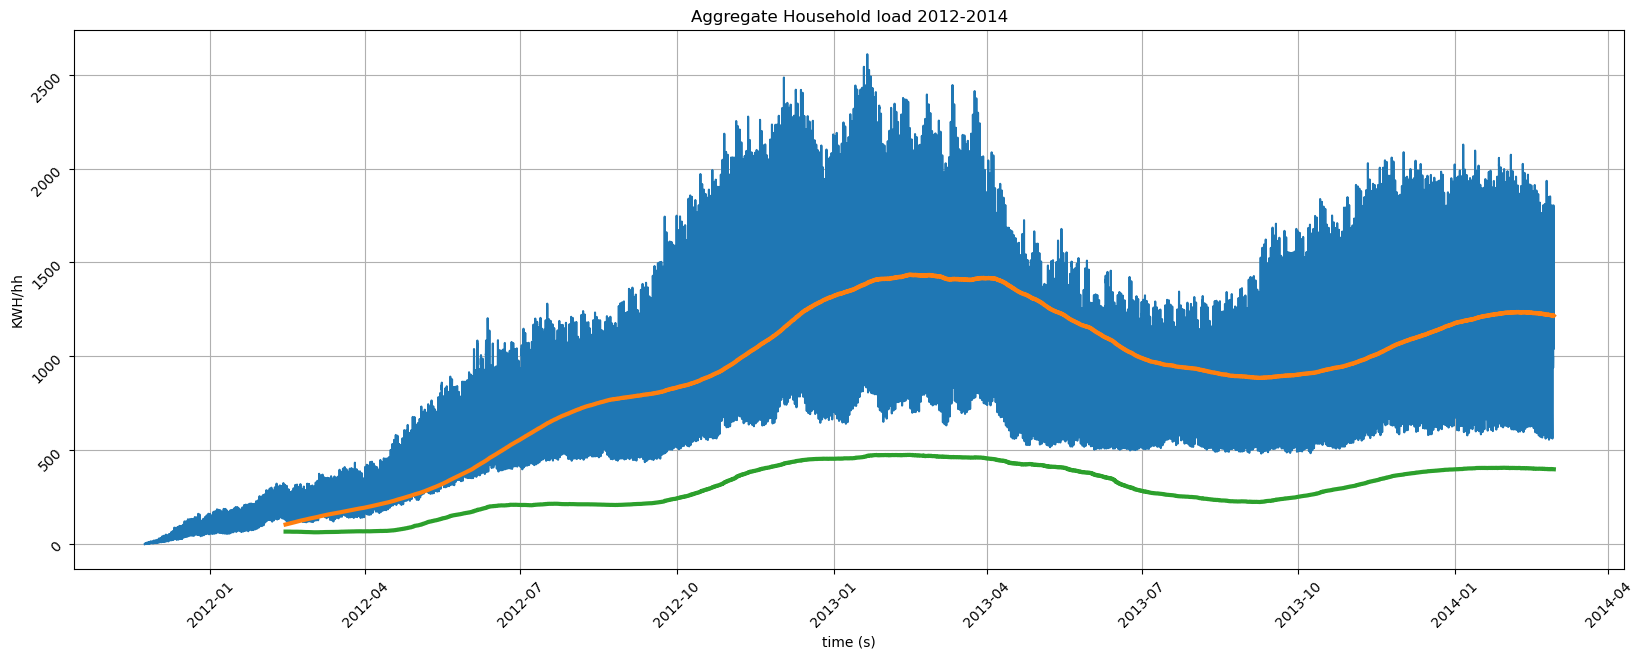

In [47]:
# Visualize aggregate load, moving average, moving standard deviation
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load 2012-2014.png")
plt.show()

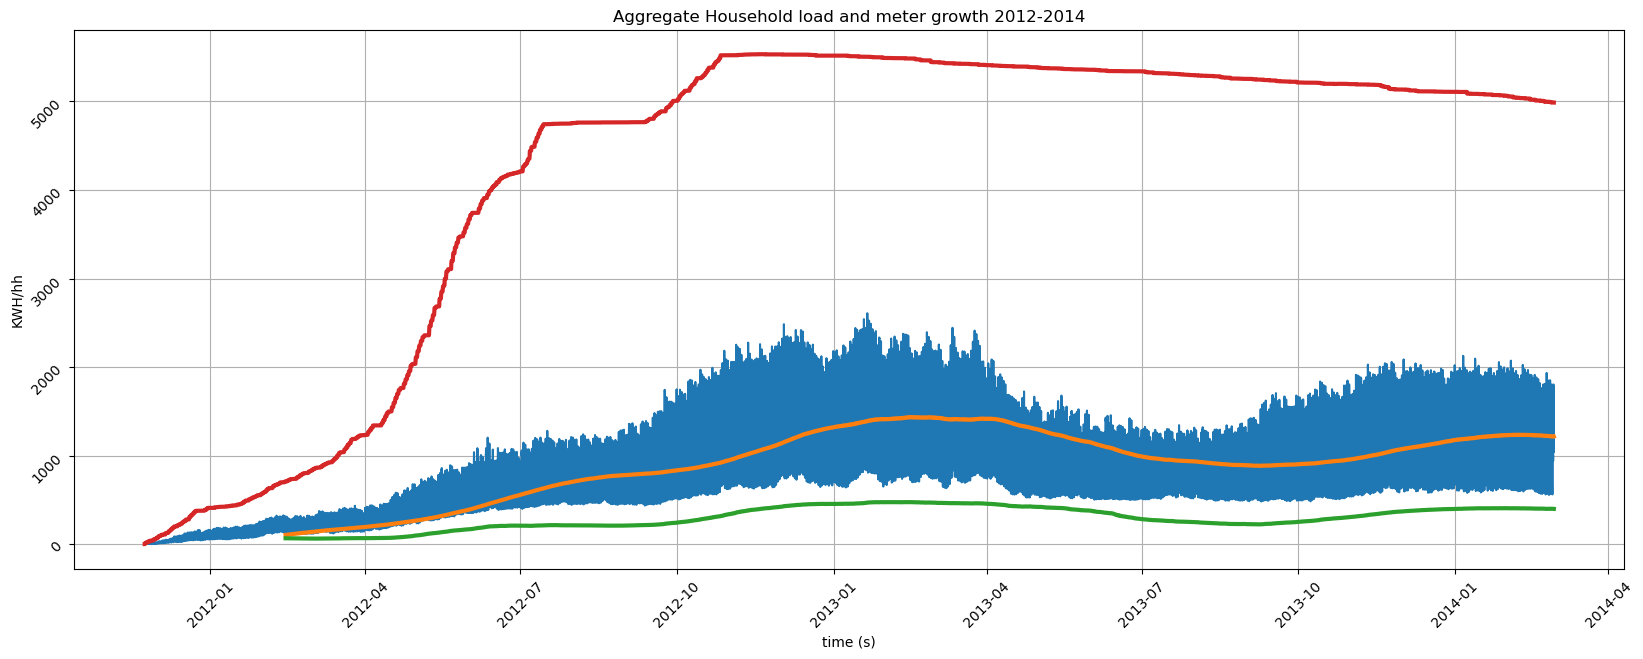

In [48]:
# Add number of meters to aggregate load, moving average, moving standard deviation
# This shows correlation of increased load with meters being added to the program during the recruitment period 
# print(aggLoad)
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime, aggLoad.AggregateLoad)
ax.plot(aggLoad.DateTime, aggLoadMovingAvg, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoadMovingStdev, linewidth=3)
ax.plot(aggLoad.DateTime, aggLoad.numMeters, linewidth=3)

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load and meter growth 2012-2014')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load and meter growth 2012-2014.png")
plt.show()

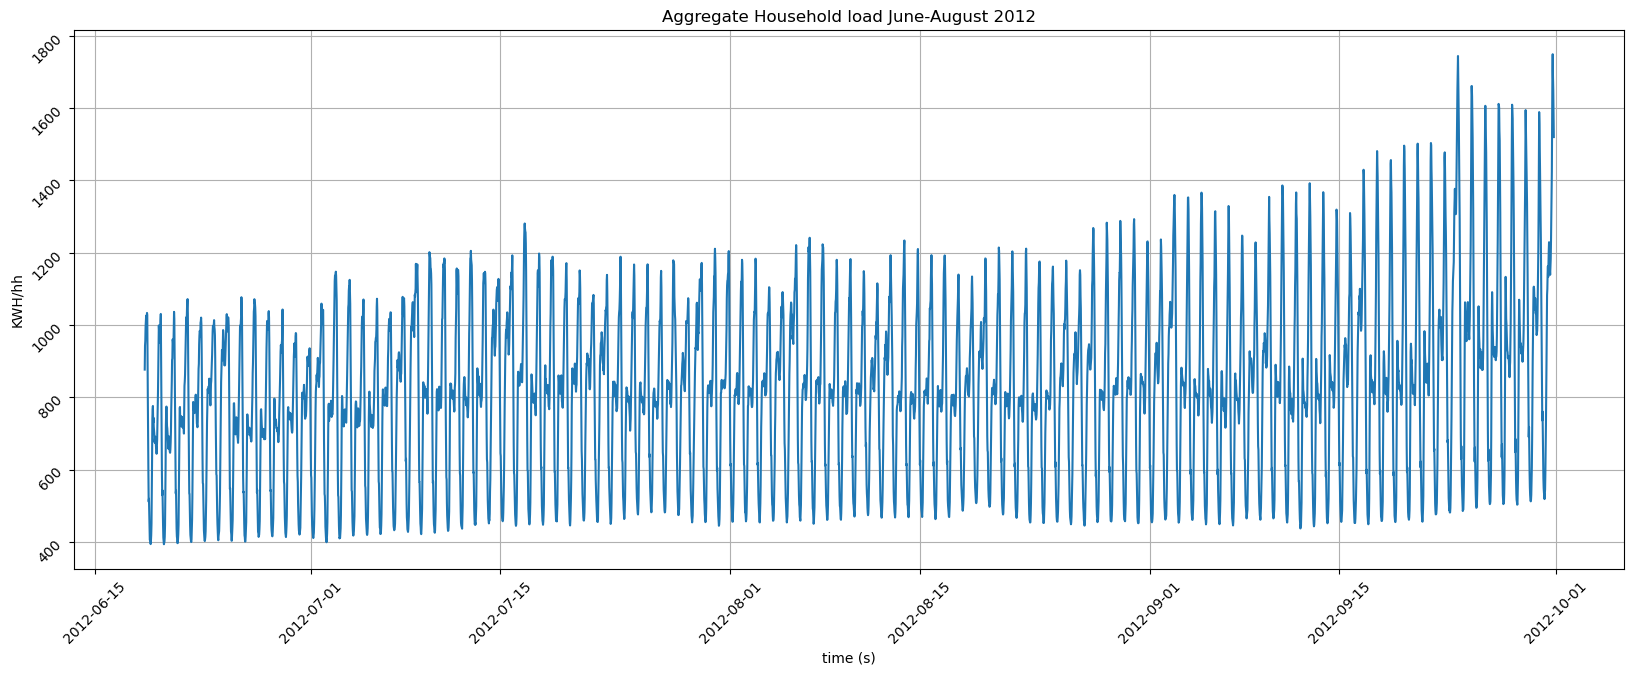

In [49]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[10000:15000], aggLoad.AggregateLoad[10000:15000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load June-August 2012')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load June-August 2012.png")
plt.show()

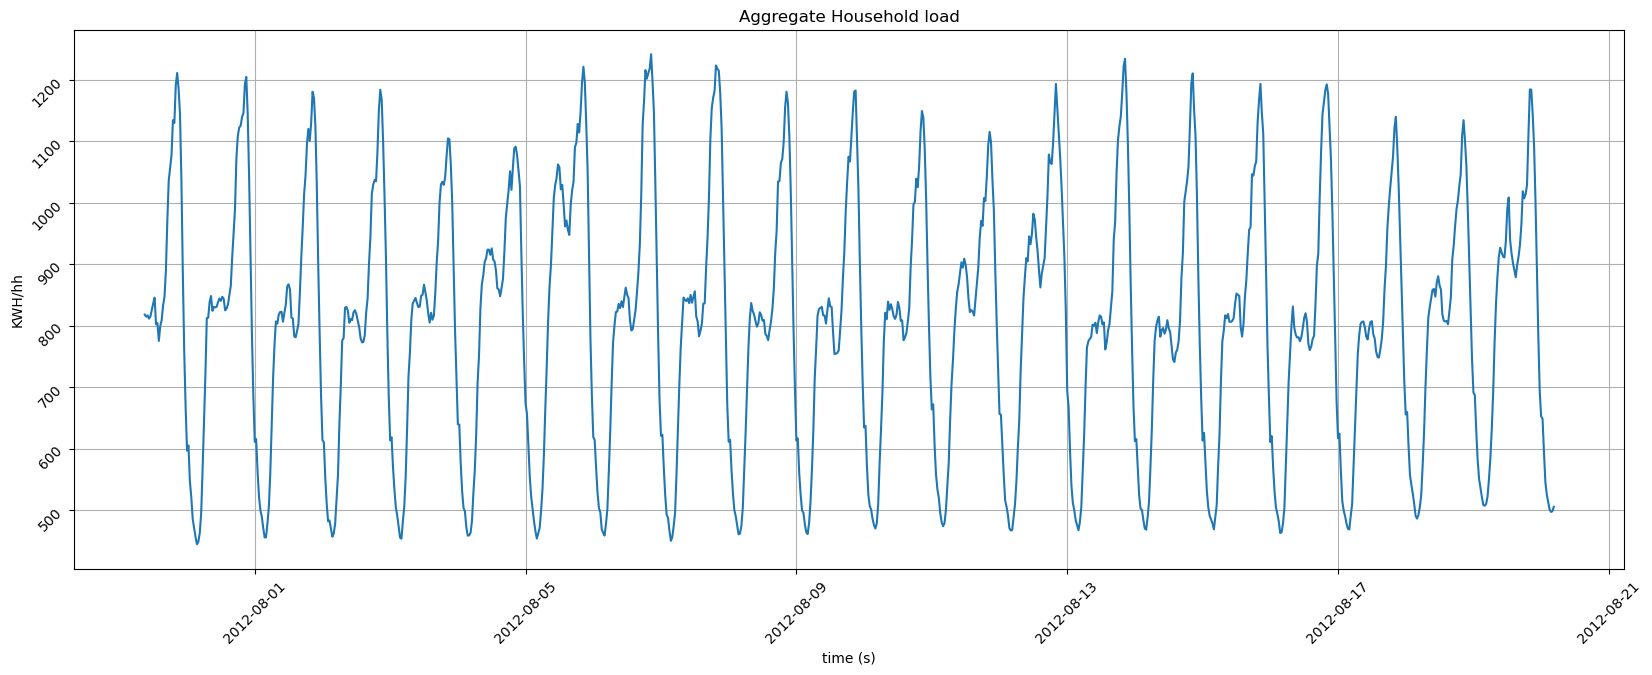

In [50]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12000:13000], aggLoad.AggregateLoad[12000:13000])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load one month.png")
plt.show()

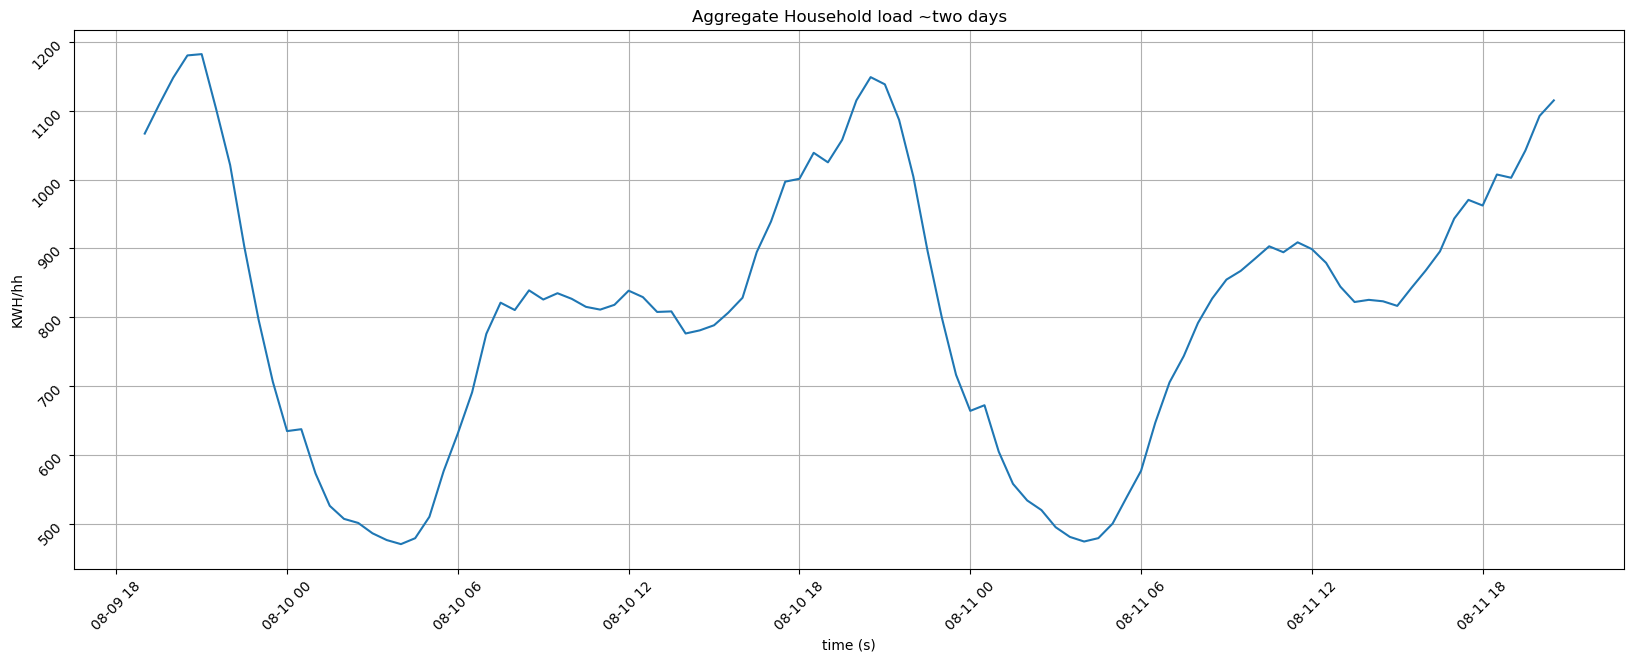

In [51]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(aggLoad.DateTime[12500:12600], aggLoad.AggregateLoad[12500:12600])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load ~two days')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load two days.png")
plt.show()

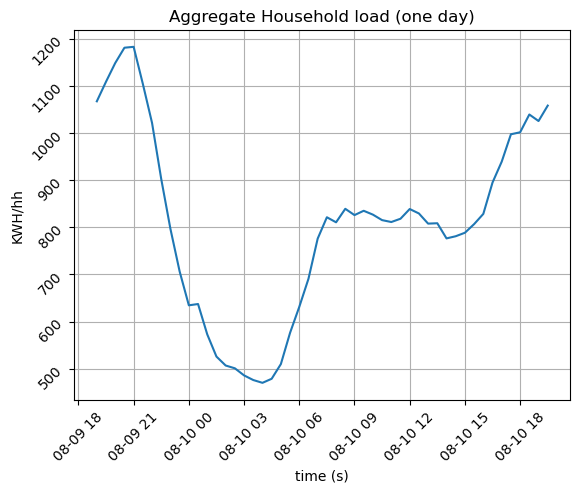

In [52]:
fig, ax = plt.subplots()
ax.plot(aggLoad.DateTime[12500:12550], aggLoad.AggregateLoad[12500:12550])

ax.set(xlabel='time (s)', ylabel='KWH/hh',
       title='Aggregate Household load (one day)')
plt.tick_params(rotation=45)
ax.grid()

fig.savefig("Aggregate Household load (one day).png")
plt.show()

In [53]:
aggLoad.to_csv('/kaggle/working/aggLoadDataFinal.csv',index=False)

In [54]:
aggLoad = pd.read_csv('/kaggle/working/aggLoadDataFinal.csv', parse_dates=["DateTime"])
aggLoad

AggregateLoad  numMeters            DateTime
0           0.569000          2 2011-11-23 09:00:00
1           0.561000          2 2011-11-23 09:30:00
2           0.920000          6 2011-11-23 10:00:00
3           0.588000          6 2011-11-23 10:30:00
4           0.772000          7 2011-11-23 11:00:00
...              ...        ...                 ...
39722    1494.829500       4987 2014-02-27 22:00:00
39723    1422.109001       4987 2014-02-27 22:30:00
39724    1258.090000       4987 2014-02-27 23:00:00
39725    1073.622001       4987 2014-02-27 23:30:00
39726    1042.266000       4987 2014-02-28 00:00:00

[39727 rows x 3 columns]

In [55]:
# Add features useful for time series
!pip install scikit-learn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

## Feature engineering

### Cyclical features

In [56]:
# Add features useful for time series
print(aggLoad.info())
# Cyclical features
# week of year
weekOfYear = aggLoad.DateTime.dt.weekofyear
aggLoad["weekOfYear_sin"] = np.sin(weekOfYear*(2.*np.pi/52))
aggLoad["weekOfYear_cos"] = np.cos(weekOfYear*(2.*np.pi/52))
# day of week
dayOfWeek = aggLoad.DateTime.dt.dayofweek
aggLoad["dayOfWeek_sin"] = np.sin(dayOfWeek*(2.*np.pi/7))
aggLoad["dayOfWeek_cos"] = np.cos(dayOfWeek*(2.*np.pi/7))
# day of year
# aggLoad["dayOfYear"] = aggLoad.DateTime.dt.dayofyear
# minute of the day
minuteOfDay = (aggLoad.DateTime.dt.hour * 60) + aggLoad.DateTime.dt.minute
aggLoad["minuteOfDay_sin"] = np.sin(minuteOfDay*(2.*np.pi/48))
aggLoad["minuteOfDay_cos"] = np.cos(minuteOfDay*(2.*np.pi/48))

cyclicalFeatureNames = ['dayOfWeek_sin', 'dayOfWeek_cos', 'minuteOfDay_sin', 'minuteOfDay_cos', 'weekOfYear_sin', 'weekOfYear_cos']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39727 entries, 0 to 39726
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   AggregateLoad  39727 non-null  float64       
 1   numMeters      39727 non-null  int64         
 2   DateTime       39727 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 931.2 KB
None


### Lag features

In [57]:
# load 1 day lag
oneDayPeriods = 48
aggLoad['AggregateLoad_1dayLag'] = aggLoad['AggregateLoad'].shift(oneDayPeriods)
# load 1 week lag
oneWeekPeriods = oneDayPeriods * 7
aggLoad['AggregateLoad_1weekLag'] = aggLoad['AggregateLoad'].shift(oneWeekPeriods)

# delete first week from dataset to remove NaNs due to lagged features
aggLoad.drop(index=aggLoad.index[:oneWeekPeriods], axis=0, inplace=True)

print(aggLoad.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39391 entries, 336 to 39726
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   AggregateLoad           39391 non-null  float64       
 1   numMeters               39391 non-null  int64         
 2   DateTime                39391 non-null  datetime64[ns]
 3   weekOfYear_sin          39391 non-null  float64       
 4   weekOfYear_cos          39391 non-null  float64       
 5   dayOfWeek_sin           39391 non-null  float64       
 6   dayOfWeek_cos           39391 non-null  float64       
 7   minuteOfDay_sin         39391 non-null  float64       
 8   minuteOfDay_cos         39391 non-null  float64       
 9   AggregateLoad_1dayLag   39391 non-null  float64       
 10  AggregateLoad_1weekLag  39391 non-null  float64       
dtypes: datetime64[ns](1), float64(9), int64(1)
memory usage: 3.3 MB
None


In [58]:
"""
# Find the earliest date when there is the maximum number of meters contributing to the aggregate load
# will disreard all data beofre this point
maxMeters = aggLoad['numMeters'].max()
print(maxMeters)
startDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()
print(startDateTime)
startDate = startDateTime.date()
print(startDate)
"""

"\n# Find the earliest date when there is the maximum number of meters contributing to the aggregate load\n# will disreard all data beofre this point\nmaxMeters = aggLoad['numMeters'].max()\nprint(maxMeters)\nstartDateTime = aggLoad[aggLoad['numMeters']==maxMeters].DateTime.min()\nprint(startDateTime)\nstartDate = startDateTime.date()\nprint(startDate)\n"

In [59]:
"""
# delete records during the ramp up phase when meters are being gradually added to the dataset
indexDate = aggLoad[ aggLoad['DateTime'].dt.date < startDate].index
aggLoad.drop(indexDate , inplace=True)
aggLoad
"""

"\n# delete records during the ramp up phase when meters are being gradually added to the dataset\nindexDate = aggLoad[ aggLoad['DateTime'].dt.date < startDate].index\naggLoad.drop(indexDate , inplace=True)\naggLoad\n"

In [60]:
# Join load data and weather data
mergeData = pd.merge(aggLoad, weatherUpsample, on='DateTime', copy=False)
print(mergeData.info())
mergeData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39391 entries, 0 to 39390
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   AggregateLoad           39391 non-null  float64       
 1   numMeters               39391 non-null  int64         
 2   DateTime                39391 non-null  datetime64[ns]
 3   weekOfYear_sin          39391 non-null  float64       
 4   weekOfYear_cos          39391 non-null  float64       
 5   dayOfWeek_sin           39391 non-null  float64       
 6   dayOfWeek_cos           39391 non-null  float64       
 7   minuteOfDay_sin         39391 non-null  float64       
 8   minuteOfDay_cos         39391 non-null  float64       
 9   AggregateLoad_1dayLag   39391 non-null  float64       
 10  AggregateLoad_1weekLag  39391 non-null  float64       
 11  temperature             39391 non-null  float64       
 12  dewPoint                39391 non-null  float6

AggregateLoad  numMeters            DateTime  weekOfYear_sin  \
0          10.951000         64 2011-11-30 09:00:00       -0.464723   
1          12.916000         66 2011-11-30 09:30:00       -0.464723   
2          12.444000         69 2011-11-30 10:00:00       -0.464723   
3          12.323000         70 2011-11-30 10:30:00       -0.464723   
4          10.693500         70 2011-11-30 11:00:00       -0.464723   
...              ...        ...                 ...             ...   
39386    1494.829500       4987 2014-02-27 22:00:00        0.885456   
39387    1422.109001       4987 2014-02-27 22:30:00        0.885456   
39388    1258.090000       4987 2014-02-27 23:00:00        0.885456   
39389    1073.622001       4987 2014-02-27 23:30:00        0.885456   
39390    1042.266000       4987 2014-02-28 00:00:00        0.885456   

       weekOfYear_cos  dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  \
0            0.885456       0.974928      -0.222521     1.000000e+00   
1            0.885456       0.974928      -0.222521    -7.071068e-01   
2            0.885456       0.974928      -0.222521     1.371976e-14   
3            0.885456       0.974928      -0.222521     7.071068e-01   
4            0.885456       0.974928      -0.222521    -1.000000e+00   
...               ...            ...            ...              ...   
39386        0.464723       0.433884      -0.900969     2.449913e-14   
39387        0.464723       0.433884      -0.900969     7.071068e-01   
39388        0.464723       0.433884      -0.900969    -1.000000e+00   
39389        0.464723       0.433884      -0.900969     7.071068e-01   
39390        0.464723      -0.433884      -0.900969     0.000000e+00   

       minuteOfDay_cos  AggregateLoad_1dayLag  AggregateLoad_1weekLag  \
0         9.790985e-16               9.500000                0.569000   
1         7.071068e-01               8.304000                0.561000   
2        -1.000000e+00               9.475000                0.920000   
3         7.071068e-01              10.045000                0.588000   
4        -1.224956e-14               9.096000                0.772000   
...                ...                    ...                     ...   
39386    -1.000000e+00            1470.095465             1480.183808   
39387     7.071068e-01            1373.472311             1381.850169   
39388    -2.302893e-14            1240.291157             1250.325528   
39389    -7.071068e-01            1032.720002             1097.076886   
39390     1.000000e+00            1021.534847             1092.776246   

       temperature  dewPoint  pressure  humidity  
0            7.660     4.960  1022.580     0.830  
1            8.695     5.475  1022.665     0.805  
2            9.730     5.990  1022.750     0.780  
3           10.510     6.040  1022.735     0.740  
4           11.290     6.090  1022.720     0.700  
...            ...       ...       ...       ...  
39386        4.100     1.640  1005.670     0.840  
39387        4.015     1.625  1005.145     0.845  
39388        3.930     1.610  1004.620     0.850  
39389        3.870     1.570  1004.095     0.850  
39390        3.810     1.530  1003.570     0.850  

[39391 rows x 15 columns]

In [61]:
# Move first column to the Last
# df = pd.DataFrame(mergeData)
df = mergeData
temp_cols=df.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
mergeData=df[new_cols]
print(mergeData)

       numMeters            DateTime  weekOfYear_sin  weekOfYear_cos  \
0             64 2011-11-30 09:00:00       -0.464723        0.885456   
1             66 2011-11-30 09:30:00       -0.464723        0.885456   
2             69 2011-11-30 10:00:00       -0.464723        0.885456   
3             70 2011-11-30 10:30:00       -0.464723        0.885456   
4             70 2011-11-30 11:00:00       -0.464723        0.885456   
...          ...                 ...             ...             ...   
39386       4987 2014-02-27 22:00:00        0.885456        0.464723   
39387       4987 2014-02-27 22:30:00        0.885456        0.464723   
39388       4987 2014-02-27 23:00:00        0.885456        0.464723   
39389       4987 2014-02-27 23:30:00        0.885456        0.464723   
39390       4987 2014-02-28 00:00:00        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.974928      -0.222521     1.000000e+00     9.790

In [62]:
from pandas_profiling import ProfileReport

profile = ProfileReport(mergeData, tsmode=True, sortby="DateTime")
profile.to_file('mergeData profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [63]:
# Remove the dateTime feature from the dataset (we've extracted to features we need from it)
print(mergeData)
mergeData.drop(columns=['DateTime'], inplace=True)

       numMeters            DateTime  weekOfYear_sin  weekOfYear_cos  \
0             64 2011-11-30 09:00:00       -0.464723        0.885456   
1             66 2011-11-30 09:30:00       -0.464723        0.885456   
2             69 2011-11-30 10:00:00       -0.464723        0.885456   
3             70 2011-11-30 10:30:00       -0.464723        0.885456   
4             70 2011-11-30 11:00:00       -0.464723        0.885456   
...          ...                 ...             ...             ...   
39386       4987 2014-02-27 22:00:00        0.885456        0.464723   
39387       4987 2014-02-27 22:30:00        0.885456        0.464723   
39388       4987 2014-02-27 23:00:00        0.885456        0.464723   
39389       4987 2014-02-27 23:30:00        0.885456        0.464723   
39390       4987 2014-02-28 00:00:00        0.885456        0.464723   

       dayOfWeek_sin  dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  \
0           0.974928      -0.222521     1.000000e+00     9.790

In [64]:
# get list of continuos features for standardization
continuousColumnNames = [e for e in mergeData.columns if e not in (cyclicalFeatureNames)]
continuousColumnNames

['numMeters',
 'AggregateLoad_1dayLag',
 'AggregateLoad_1weekLag',
 'temperature',
 'dewPoint',
 'pressure',
 'humidity',
 'AggregateLoad']

In [65]:
mergeData.to_csv('/kaggle/working/mergeDataFinal.csv',index=False)

In [66]:
mergeData = pd.read_csv('/kaggle/working/mergeDataFinal.csv')
mergeData

numMeters  weekOfYear_sin  weekOfYear_cos  dayOfWeek_sin  \
0             64       -0.464723        0.885456       0.974928   
1             66       -0.464723        0.885456       0.974928   
2             69       -0.464723        0.885456       0.974928   
3             70       -0.464723        0.885456       0.974928   
4             70       -0.464723        0.885456       0.974928   
...          ...             ...             ...            ...   
39386       4987        0.885456        0.464723       0.433884   
39387       4987        0.885456        0.464723       0.433884   
39388       4987        0.885456        0.464723       0.433884   
39389       4987        0.885456        0.464723       0.433884   
39390       4987        0.885456        0.464723      -0.433884   

       dayOfWeek_cos  minuteOfDay_sin  minuteOfDay_cos  AggregateLoad_1dayLag  \
0          -0.222521     1.000000e+00     9.790985e-16               9.500000   
1          -0.222521    -7.071068e-01     7.071068e-01               8.304000   
2          -0.222521     1.371976e-14    -1.000000e+00               9.475000   
3          -0.222521     7.071068e-01     7.071068e-01              10.045000   
4          -0.222521    -1.000000e+00    -1.224956e-14               9.096000   
...              ...              ...              ...                    ...   
39386      -0.900969     2.449913e-14    -1.000000e+00            1470.095465   
39387      -0.900969     7.071068e-01     7.071068e-01            1373.472311   
39388      -0.900969    -1.000000e+00    -2.302893e-14            1240.291157   
39389      -0.900969     7.071068e-01    -7.071068e-01            1032.720002   
39390      -0.900969     0.000000e+00     1.000000e+00            1021.534847   

       AggregateLoad_1weekLag  temperature  dewPoint  pressure  humidity  \
0                    0.569000        7.660     4.960  1022.580     0.830   
1                    0.561000        8.695     5.475  1022.665     0.805   
2                    0.920000        9.730     5.990  1022.750     0.780   
3                    0.588000       10.510     6.040  1022.735     0.740   
4                    0.772000       11.290     6.090  1022.720     0.700   
...                       ...          ...       ...       ...       ...   
39386             1480.183808        4.100     1.640  1005.670     0.840   
39387             1381.850169        4.015     1.625  1005.145     0.845   
39388             1250.325528        3.930     1.610  1004.620     0.850   
39389             1097.076886        3.870     1.570  1004.095     0.850   
39390             1092.776246        3.810     1.530  1003.570     0.850   

       AggregateLoad  
0          10.951000  
1          12.916000  
2          12.444000  
3          12.323000  
4          10.693500  
...              ...  
39386    1494.829500  
39387    1422.109001  
39388    1258.090000  
39389    1073.622001  
39390    1042.266000  

[39391 rows x 14 columns]

## Plot autocorrelation of aggregate load (target) to investigate cyclical properties

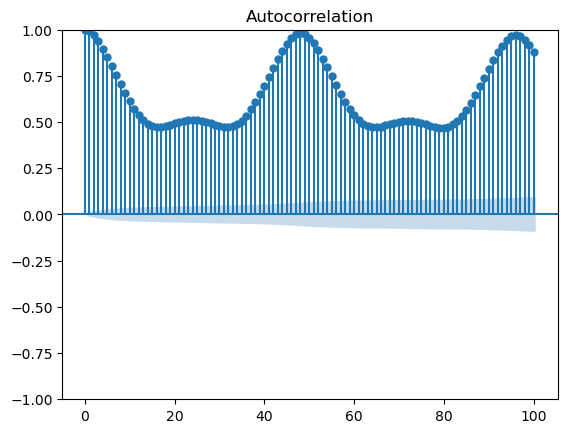

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the AggregateLoad feature
aggregate_load = mergeData['AggregateLoad']

# Plot the autocorrelation plot
plot_acf(aggregate_load, lags=100)

# Show the plot
plt.show()

## Final feature selection

In [68]:
# select features
# mergeData = mergeData[['AggregateLoad_1dayLag', 'AggregateLoad_1weekLag', 'dayOfWeek', 'temperature','AggregateLoad']]
mergeData = mergeData[['minuteOfDay_sin', 'minuteOfDay_cos', 'dayOfWeek_sin', 'dayOfWeek_cos', 'weekOfYear_sin', 'weekOfYear_cos', 'AggregateLoad']]
# mergeData = mergeData[['AggregateLoad']]
mergeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39391 entries, 0 to 39390
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minuteOfDay_sin  39391 non-null  float64
 1   minuteOfDay_cos  39391 non-null  float64
 2   dayOfWeek_sin    39391 non-null  float64
 3   dayOfWeek_cos    39391 non-null  float64
 4   weekOfYear_sin   39391 non-null  float64
 5   weekOfYear_cos   39391 non-null  float64
 6   AggregateLoad    39391 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB


## Training, Validation, Testing Split

In [69]:
# Split the time series data into train, test, and validation datasets
train_size = int(len(mergeData) * 0.7)  # 70% for training
val_size = int(len(mergeData) * 0.2)   # 20% for validation
test_size = len(mergeData) - val_size - train_size  # Remaining 10% for testing

train_data = mergeData[:train_size].copy()
val_data = mergeData[train_size:train_size+val_size].copy()
test_data = mergeData[train_size+val_size:].copy()

print('\ntrain_data.head()\n', train_data.head())
print(train_data.info())
print('\nval_data.head()\n', val_data.head())
print(val_data.info())
print('\ntest_data.head()\n', test_data.head())
print(test_data.info())

num_features = mergeData.shape[1]


train_data.head()
    minuteOfDay_sin  minuteOfDay_cos  dayOfWeek_sin  dayOfWeek_cos  \
0     1.000000e+00     9.790985e-16       0.974928      -0.222521   
1    -7.071068e-01     7.071068e-01       0.974928      -0.222521   
2     1.371976e-14    -1.000000e+00       0.974928      -0.222521   
3     7.071068e-01     7.071068e-01       0.974928      -0.222521   
4    -1.000000e+00    -1.224956e-14       0.974928      -0.222521   

   weekOfYear_sin  weekOfYear_cos  AggregateLoad  
0       -0.464723        0.885456        10.9510  
1       -0.464723        0.885456        12.9160  
2       -0.464723        0.885456        12.4440  
3       -0.464723        0.885456        12.3230  
4       -0.464723        0.885456        10.6935  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27573 entries, 0 to 27572
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minuteOfDay_sin  27573 non-null  float64
 1   minuteOf

In [70]:
def prediction_plot(testY, test_predict):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(20,5))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('KWH per half hour', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.show();

## Standardize the data

In [71]:
# Standardize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

mergeDataNormed = (mergeData - train_mean) / train_std

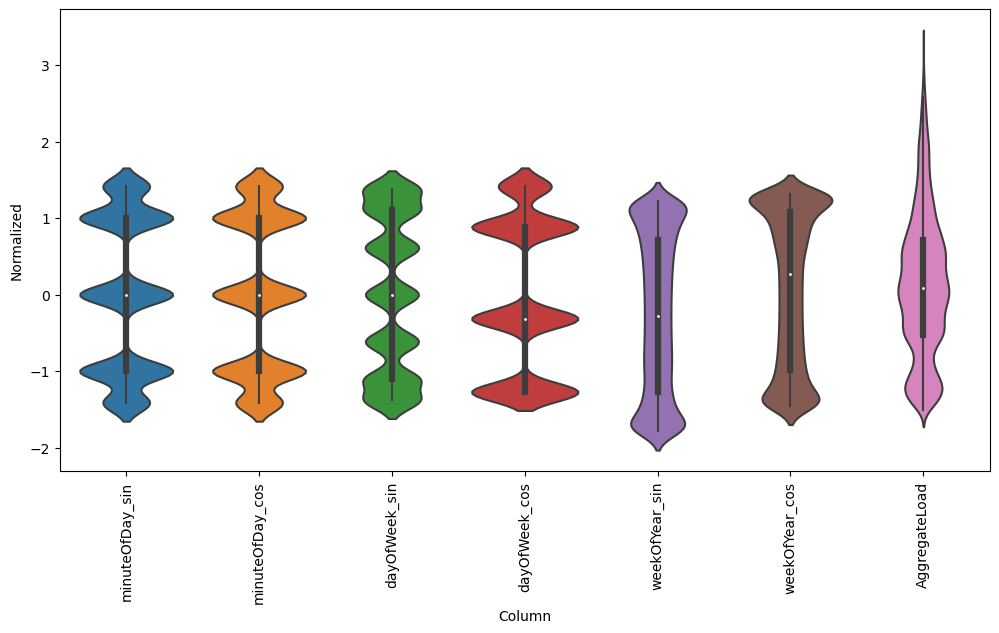

In [72]:
# Visualize distribution of the features
# df_std = (mergeData - train_mean) / train_std
df_std = mergeDataNormed.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(mergeData.keys(), rotation=90)
plt.savefig('violin_plot.png', format='png')


## Functions for preparing data for time series machine learning

Not my work

Credit to [Tensorflow Tutorial: Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [73]:
class WindowGenerator():
    # https://www.tensorflow.org/tutorials/structured_data/time_series#1_indexes_and_offsets
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    print('\nWindowGenerator.__init__\n')
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    print('\nlabel_columns:\n', label_columns)
    # Work out the label column indices.
    self.label_columns = label_columns
    
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [74]:
def split_window(self, features):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#2_split
  # print('\nsplit_window\n', features)
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [75]:
def plot(self, model=None, plot_col='AggregateLoad', max_subplots=3):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#3_plot
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [76]:
def make_dataset(self, data):
    # https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
  # print('\nmake_dataset\n', data)
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      seed=randomState,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [77]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#4_create_tfdatadatasets
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Create data windows for time series forecasting


WindowGenerator.__init__


label_columns:
 ['AggregateLoad']


Total window size: 96
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label column name(s): ['AggregateLoad']

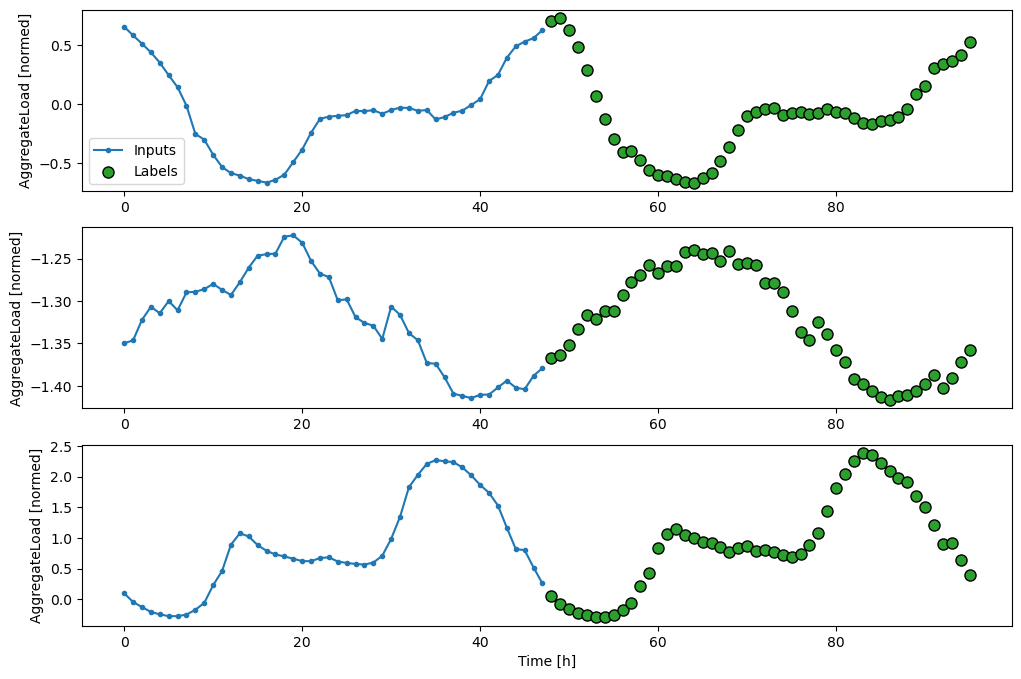

In [78]:
# Prepare data for one-shot multi-step
OUT_STEPS = 48 # 24 hour forecast
# IN_STEPS = 336 # look back 1 week
IN_STEPS = 48 # look back 1 day
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['AggregateLoad'],
                              train_df=train_data, val_df=val_data, test_df=test_data,)

multi_window.plot()
multi_window

# Build and Train models

## Baseline naive persistence model

Use a 1 week persistence model as a baseline to evaluate performance of the machine learning models we are building

Georgios Tziolis, Chrysovalantis Spanias, Maria Theodoride, Spyros Theocharides, Javier Lopez-Lorente, Andreas Livera, George Makrides, George E. Georghiou,

Short-term electric net load forecasting for solar-integrated distribution systems based on Bayesian neural networks and statistical post-processing,

Energy,
Volume 271,
2023,
127018,
ISSN 0360-5442,

https://doi.org/10.1016/j.energy.2023.127018.

In [79]:
# capture performnce of models
multi_val_performance = {}
multi_test_performance = {}

### Function to compile and fit models

In [80]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=5):
  # https://www.tensorflow.org/tutorials/structured_data/time_series#linear_model
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  checkpoint_filepath = '/tmp/' + model.name + '/checkpoint'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                    monitor="val_loss", mode="min", 
                    save_best_only=True, verbose=1)
    
  # print('\nwindow.train:\n', window.train)  
  # print('\nwindow.val:\n', window.val)  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, checkpoint])

  # restore weights from epoch with best loss against validation dataset
  model.load_weights(checkpoint_filepath)
    
  return history


In [81]:
# Baseline Model: Naive 1 week persistence
OneWeekNPeriods = 48 * 7
NaiveForecast = mergeData.AggregateLoad.shift(OneWeekNPeriods).copy()

print(NaiveForecast.info())
print(NaiveForecast.describe())

<class 'pandas.core.series.Series'>
RangeIndex: 39391 entries, 0 to 39390
Series name: AggregateLoad
Non-Null Count  Dtype  
--------------  -----  
39055 non-null  float64
dtypes: float64(1)
memory usage: 307.9 KB
None
count    39055.000000
mean       902.240601
std        514.731385
min          7.664000
25%        538.838233
50%        879.585873
75%       1224.902846
max       2608.409794
Name: AggregateLoad, dtype: float64


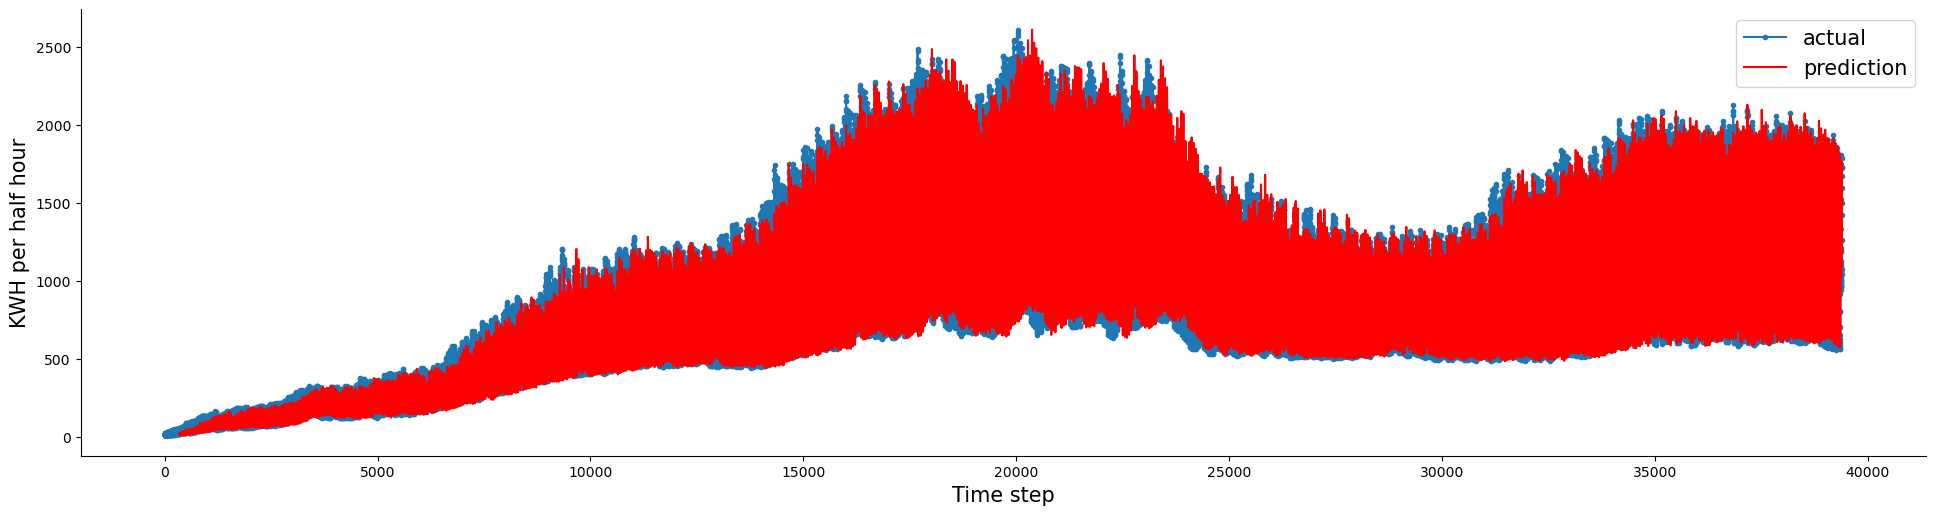

In [82]:
# visualize naive forecast and actuals for entire dataset
prediction_plot(mergeData.AggregateLoad, NaiveForecast)

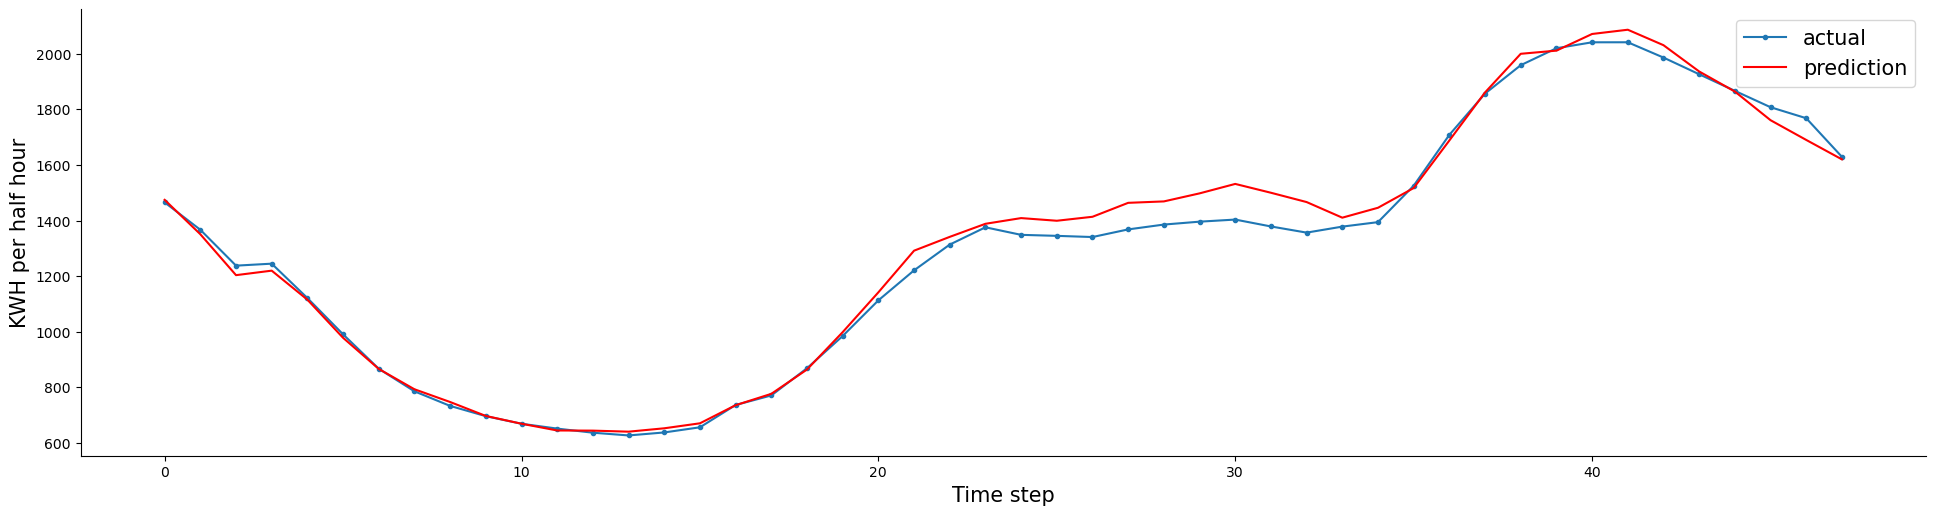

In [83]:
# visualize naive forecast and actuals for first 24 hours of the test dataset
# print(train_size, val_size, test_size)
# print(train_size+val_size)
prediction_plot(mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])

In [84]:
# normalize the naive 
# (NaiveForecast - train_mean) / train_std
NaiveForecastNormed = NaiveForecast.transform(lambda x: (x - train_mean) / train_std)
NaiveForecastNormed.describe()

minuteOfDay_sin  minuteOfDay_cos  dayOfWeek_sin  dayOfWeek_cos  \
count     39055.000000     39055.000000   39055.000000   39055.000000   
mean       1275.914620      1275.960874    1275.499866    1276.376027   
std         727.913706       727.940106     727.677687     728.176804   
min          10.838140        10.838511      10.833576      10.842297   
25%         762.004700       762.032315     761.756577     762.280359   
50%        1243.877158      1243.922250    1243.472793    1244.326986   
75%        1732.211393      1732.274196    1731.648689    1732.837724   
max        3688.714724      3688.848486    3687.517642    3690.048216   

       weekOfYear_sin  weekOfYear_cos  AggregateLoad  
count    39055.000000    39055.000000   39055.000000  
mean      1354.233833     1253.343956       0.125230  
std        772.756971      715.076487       0.937038  
min         11.222071       10.577900      -1.503295  
25%        808.664393      748.497163      -0.536323  
50%       1320.222698     1221.871495       0.083988  
75%       1838.640858     1701.593646       0.712618  
max       3915.674957     3623.592803       3.231211

In [85]:
# calculate error for naive model (Normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)

valNaiveMAE:  0.0877738847555856
testNaiveMAE:  0.11423401714728926


In [86]:
# calculate error for naive model (not normed)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
print('Naive Root Mean Squared Error(RMSE): %.2f; Naive Mean Absolute Error(MAE) : %.2f; Naive Mean Absolute Percantage Error(MAPE) : %.2f '
      % (np.sqrt(mean_squared_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])),
         mean_absolute_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:]),
         mean_absolute_percentage_error(mergeData.AggregateLoad[OneWeekNPeriods:], NaiveForecast[OneWeekNPeriods:])))

# calculate error for naive model on validation set
valNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size:train_size+val_size], NaiveForecast[train_size:train_size+val_size])

# calculate error for naive model on test set
testNaiveMAE = mean_absolute_error(mergeData.AggregateLoad[train_size+val_size:], NaiveForecast[train_size+val_size:])

print('valNaiveMAE: ', valNaiveMAE)
print('testNaiveMAE: ', testNaiveMAE)


Naive Root Mean Squared Error(RMSE): 93.00; Naive Mean Absolute Error(MAE) : 60.62; Naive Mean Absolute Percantage Error(MAPE) : 0.08 
valNaiveMAE:  48.21570919594345
testNaiveMAE:  62.75071641633833


In [87]:
# function for plotting the train and test loss curves
def plot_model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show()
    return

In [88]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Baseline Persistence'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size:train_size+val_size], NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size], verbose=0)
multi_test_performance['Baseline Persistence'] = repeat_baseline.evaluate(mergeDataNormed.AggregateLoad[train_size+val_size:], NaiveForecastNormed.AggregateLoad[train_size+val_size:], verbose=0)
print(multi_val_performance['Baseline Persistence'], multi_test_performance['Baseline Persistence'])

[0.01659751869738102, 0.0877738818526268] [0.03284890204668045, 0.11423403024673462]


Epoch 1/100
838/859 [============================>.] - ETA: 0s - loss: 0.3674 - mean_absolute_error: 0.4389
Epoch 1: val_loss improved from inf to 0.25892, saving model to /tmp/sequential/checkpoint
859/859 [==============================] - 4s 4ms/step - loss: 0.3651 - mean_absolute_error: 0.4373 - val_loss: 0.2589 - val_mean_absolute_error: 0.3979
Epoch 2/100
836/859 [============================>.] - ETA: 0s - loss: 0.2562 - mean_absolute_error: 0.3682
Epoch 2: val_loss improved from 0.25892 to 0.24469, saving model to /tmp/sequential/checkpoint
859/859 [==============================] - 3s 4ms/step - loss: 0.2563 - mean_absolute_error: 0.3682 - val_loss: 0.2447 - val_mean_absolute_error: 0.3852
Epoch 3/100
853/859 [============================>.] - ETA: 0s - loss: 0.2339 - mean_absolute_error: 0.3511
Epoch 3: val_loss improved from 0.24469 to 0.23118, saving model to /tmp/sequential/checkpoint
859/859 [==============================] - 3s 3ms/step - loss: 0.2338 - mean_absolute_err

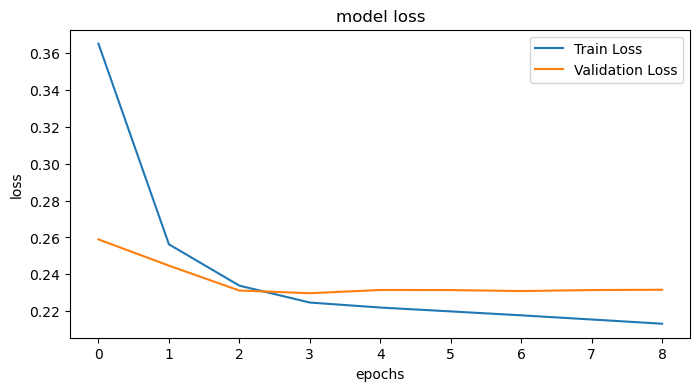

244/244 [==============================] - 1s 2ms/step - loss: 0.2297 - mean_absolute_error: 0.3658


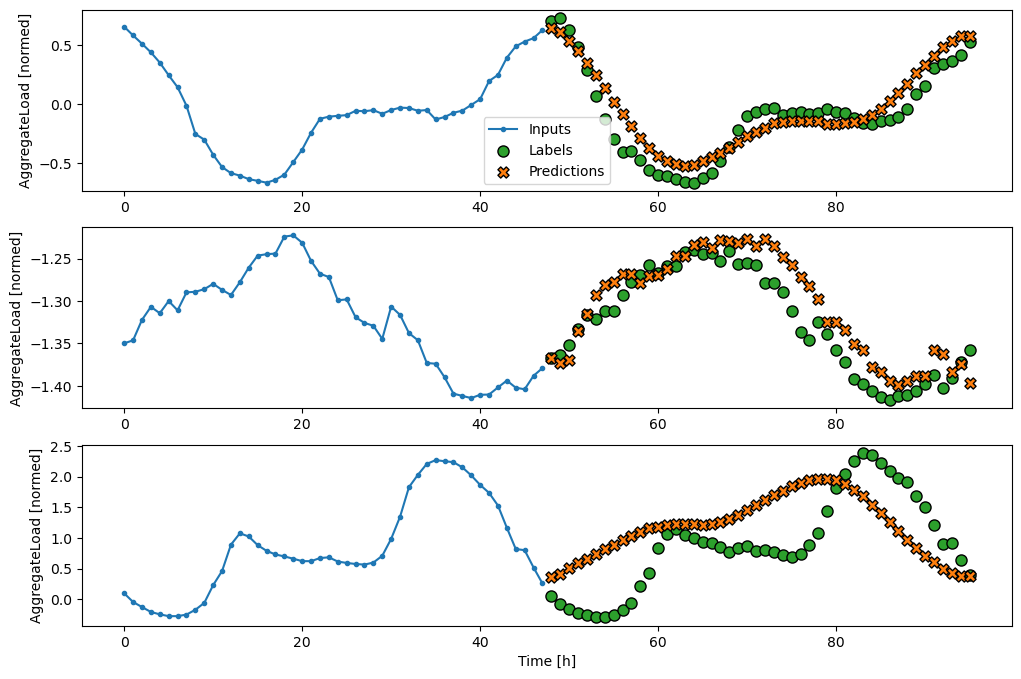

In [89]:
multi_MLP_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(64, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_MLP_model, multi_window)
multi_MLP_model.save('multi_MLP_model.keras')
plot_model_loss(history)

# IPython.display.clear_output()
multi_val_performance['MLP'] = multi_MLP_model.evaluate(multi_window.val)
multi_test_performance['MLP'] = multi_MLP_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_MLP_model)

In [90]:
num_features

7

# CNN

Convolutional Neural Network

Epoch 1/100
839/859 [============================>.] - ETA: 0s - loss: 0.2391 - mean_absolute_error: 0.3437
Epoch 1: val_loss improved from inf to 0.15831, saving model to /tmp/sequential_1/checkpoint
859/859 [==============================] - 4s 4ms/step - loss: 0.2373 - mean_absolute_error: 0.3423 - val_loss: 0.1583 - val_mean_absolute_error: 0.2978
Epoch 2/100
841/859 [============================>.] - ETA: 0s - loss: 0.1198 - mean_absolute_error: 0.2457
Epoch 2: val_loss improved from 0.15831 to 0.09958, saving model to /tmp/sequential_1/checkpoint
859/859 [==============================] - 3s 3ms/step - loss: 0.1194 - mean_absolute_error: 0.2453 - val_loss: 0.0996 - val_mean_absolute_error: 0.2342
Epoch 3/100
845/859 [============================>.] - ETA: 0s - loss: 0.0919 - mean_absolute_error: 0.2148
Epoch 3: val_loss improved from 0.09958 to 0.09861, saving model to /tmp/sequential_1/checkpoint
859/859 [==============================] - 3s 4ms/step - loss: 0.0919 - mean_absolu

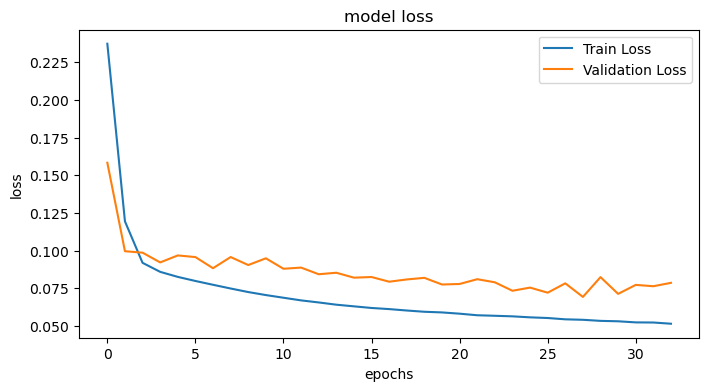

244/244 [==============================] - 1s 2ms/step - loss: 0.0692 - mean_absolute_error: 0.1881


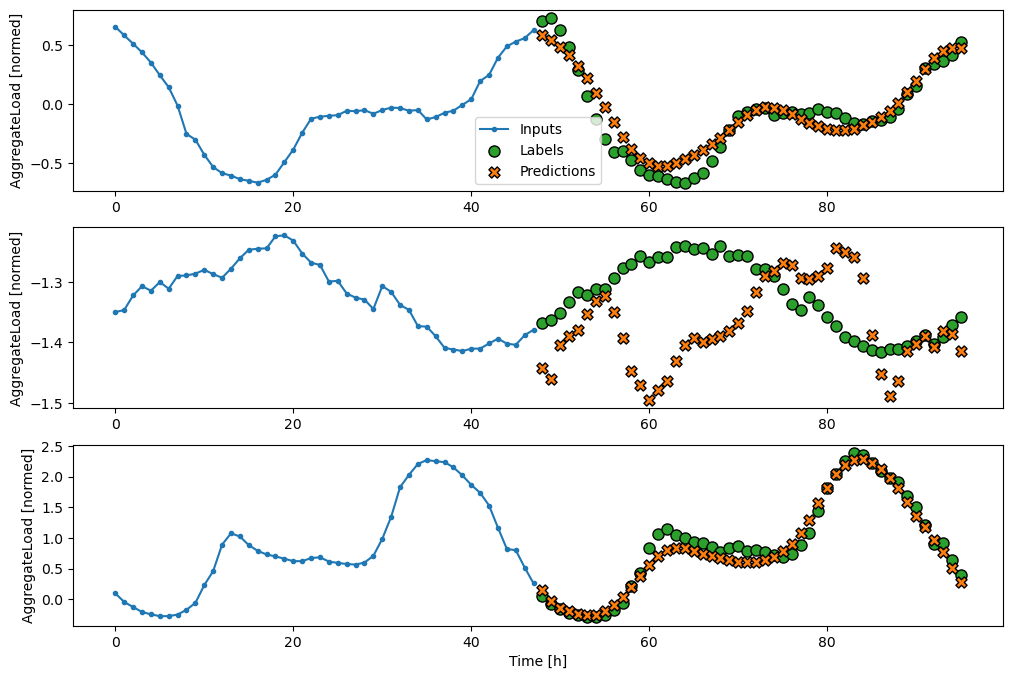

In [91]:
CONV_WIDTH = 10
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)
multi_conv_model.save('multi_conv_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_test_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)


Epoch 1/100
857/859 [============================>.] - ETA: 0s - loss: 0.1449 - mean_absolute_error: 0.2549
Epoch 1: val_loss improved from inf to 0.03472, saving model to /tmp/sequential_2/checkpoint
859/859 [==============================] - 11s 12ms/step - loss: 0.1447 - mean_absolute_error: 0.2547 - val_loss: 0.0347 - val_mean_absolute_error: 0.1450
Epoch 2/100
857/859 [============================>.] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.1214
Epoch 2: val_loss improved from 0.03472 to 0.02459, saving model to /tmp/sequential_2/checkpoint
859/859 [==============================] - 10s 11ms/step - loss: 0.0273 - mean_absolute_error: 0.1214 - val_loss: 0.0246 - val_mean_absolute_error: 0.1215
Epoch 3/100
858/859 [============================>.] - ETA: 0s - loss: 0.0235 - mean_absolute_error: 0.1124
Epoch 3: val_loss improved from 0.02459 to 0.02134, saving model to /tmp/sequential_2/checkpoint
859/859 [==============================] - 10s 12ms/step - loss: 0.0235 - mean_

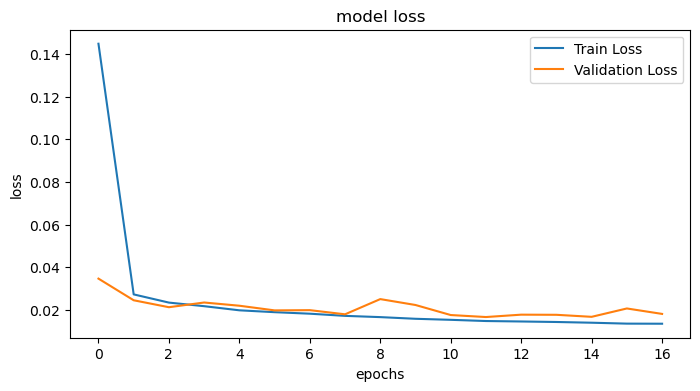

244/244 [==============================] - 1s 4ms/step - loss: 0.0167 - mean_absolute_error: 0.0978


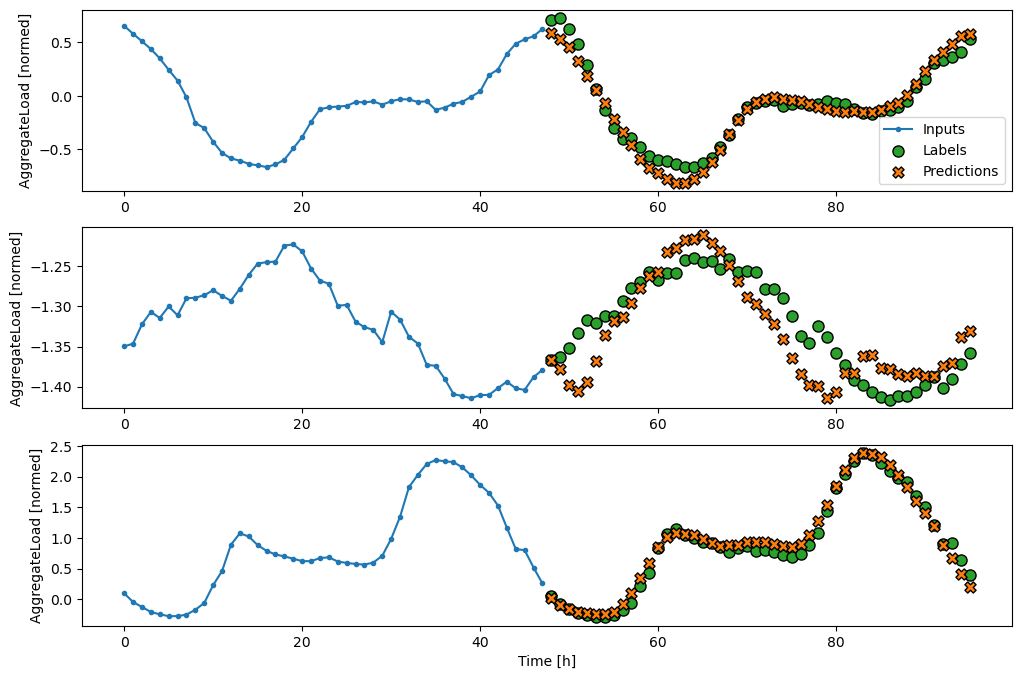

In [92]:
multi_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_rnn_model, multi_window)
plot_model_loss(history)
multi_rnn_model.save('multi_rnn_model.keras')
# IPython.display.clear_output()

multi_val_performance['RNN'] = multi_rnn_model.evaluate(multi_window.val)
multi_test_performance['RNN'] = multi_rnn_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_rnn_model)

# LSTM Model

Epoch 1/100
859/859 [==============================] - ETA: 0s - loss: 0.1368 - mean_absolute_error: 0.2410
Epoch 1: val_loss improved from inf to 0.02150, saving model to /tmp/sequential_3/checkpoint
859/859 [==============================] - 25s 27ms/step - loss: 0.1368 - mean_absolute_error: 0.2410 - val_loss: 0.0215 - val_mean_absolute_error: 0.1144
Epoch 2/100
858/859 [============================>.] - ETA: 0s - loss: 0.0198 - mean_absolute_error: 0.1018
Epoch 2: val_loss improved from 0.02150 to 0.01648, saving model to /tmp/sequential_3/checkpoint
859/859 [==============================] - 23s 27ms/step - loss: 0.0198 - mean_absolute_error: 0.1018 - val_loss: 0.0165 - val_mean_absolute_error: 0.0981
Epoch 3/100
859/859 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.0885
Epoch 3: val_loss improved from 0.01648 to 0.01525, saving model to /tmp/sequential_3/checkpoint
859/859 [==============================] - 23s 27ms/step - loss: 0.0155 - mean_

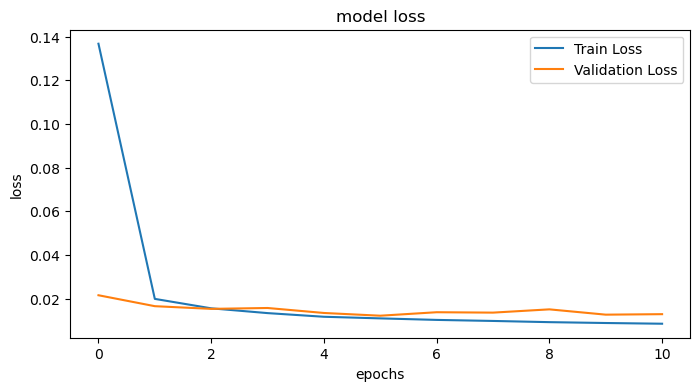

244/244 [==============================] - 2s 8ms/step - loss: 0.0121 - mean_absolute_error: 0.0832


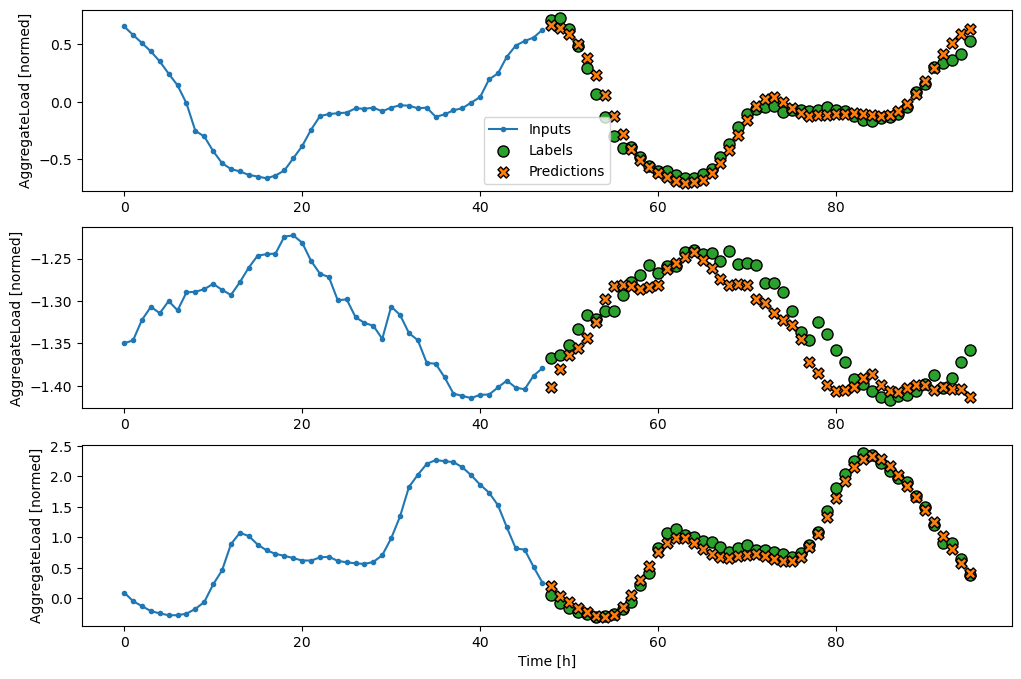

In [93]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(64,return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

start_time = time.time()
history = compile_and_fit(multi_lstm_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_lstm_model.save('multi_lstm_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)


# GRU Model

Epoch 1/100
858/859 [============================>.] - ETA: 0s - loss: 0.1534 - mean_absolute_error: 0.2564
Epoch 1: val_loss improved from inf to 0.02601, saving model to /tmp/sequential_4/checkpoint
859/859 [==============================] - 25s 27ms/step - loss: 0.1532 - mean_absolute_error: 0.2562 - val_loss: 0.0260 - val_mean_absolute_error: 0.1235
Epoch 2/100
859/859 [==============================] - ETA: 0s - loss: 0.0223 - mean_absolute_error: 0.1073
Epoch 2: val_loss improved from 0.02601 to 0.01828, saving model to /tmp/sequential_4/checkpoint
859/859 [==============================] - 22s 25ms/step - loss: 0.0223 - mean_absolute_error: 0.1073 - val_loss: 0.0183 - val_mean_absolute_error: 0.1039
Epoch 3/100
858/859 [============================>.] - ETA: 0s - loss: 0.0180 - mean_absolute_error: 0.0951
Epoch 3: val_loss improved from 0.01828 to 0.01636, saving model to /tmp/sequential_4/checkpoint
859/859 [==============================] - 22s 25ms/step - loss: 0.0180 - mean_

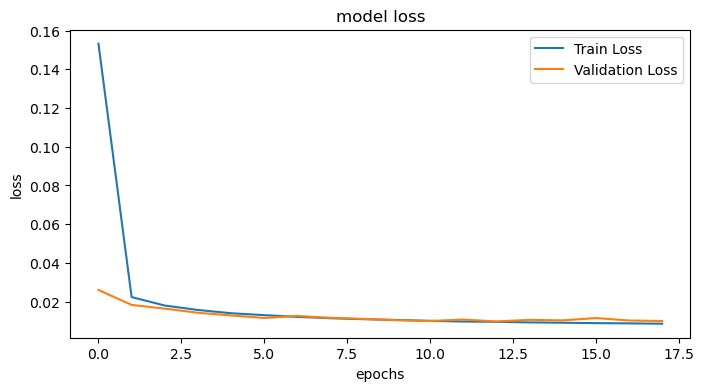

244/244 [==============================] - 2s 7ms/step - loss: 0.0097 - mean_absolute_error: 0.0740


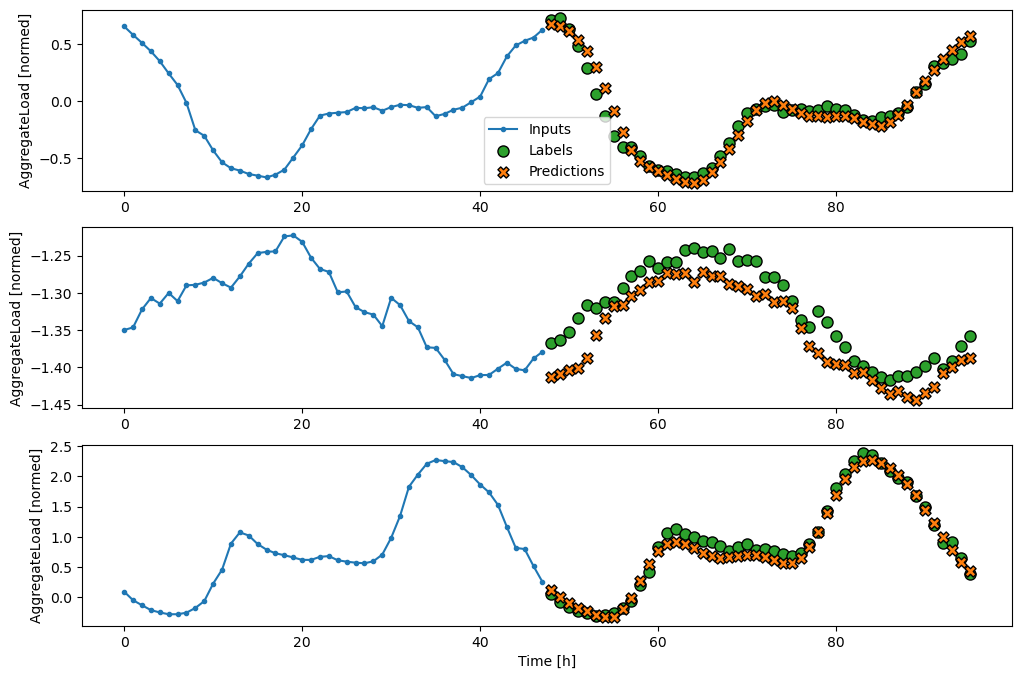

In [94]:
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

start_time = time.time()
history = compile_and_fit(multi_gru_model, multi_window)
print('%s seconds' % (time.time() - start_time))
multi_gru_model.save('multi_gru_model.keras')
plot_model_loss(history)
# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model.evaluate(multi_window.val)
multi_test_performance['GRU'] = multi_gru_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_gru_model)

# Model Evaluation and Selection

In [95]:
print(multi_val_performance)
print(multi_test_performance)

{'Baseline Persistence': [0.01659751869738102, 0.0877738818526268], 'MLP': [0.22972020506858826, 0.36576876044273376], 'Conv': [0.06924603879451752, 0.18811295926570892], 'RNN': [0.016737354919314384, 0.09782513976097107], 'LSTM': [0.012115657329559326, 0.08323749154806137], 'GRU': [0.009736165404319763, 0.07404384762048721]}
{'Baseline Persistence': [0.03284890204668045, 0.11423403024673462], 'MLP': [0.5703104138374329, 0.5870031118392944], 'Conv': [0.20634570717811584, 0.32023507356643677], 'RNN': [0.03933198004961014, 0.15022392570972443], 'LSTM': [0.026004940271377563, 0.12157697230577469], 'GRU': [0.023020843043923378, 0.11016905307769775]}


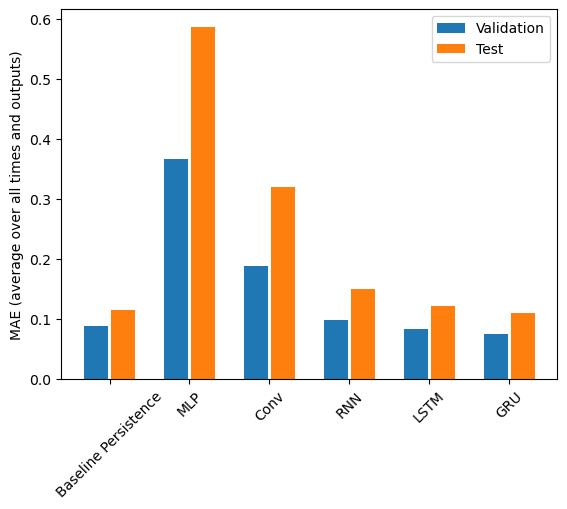

In [96]:
x = np.arange(len(multi_test_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_test_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_test_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.savefig('model performance.png', format='png')


In [97]:
# store the evaluation results for all models
import pickle
with open('model eval results.pkl', 'wb') as f:
    pickle.dump(multi_val_performance, f)

with open('model eval results.pkl', 'rb') as f:
    multi_val_performance = pickle.load(f)


with open('model test results.pkl', 'wb') as f:
    pickle.dump(multi_test_performance, f)

with open('model test results.pkl', 'rb') as f:
    multi_test_performance = pickle.load(f)

print(multi_val_performance)
print(multi_test_performance)

{'Baseline Persistence': [0.01659751869738102, 0.0877738818526268], 'MLP': [0.22972020506858826, 0.36576876044273376], 'Conv': [0.06924603879451752, 0.18811295926570892], 'RNN': [0.016737354919314384, 0.09782513976097107], 'LSTM': [0.012115657329559326, 0.08323749154806137], 'GRU': [0.009736165404319763, 0.07404384762048721]}
{'Baseline Persistence': [0.03284890204668045, 0.11423403024673462], 'MLP': [0.5703104138374329, 0.5870031118392944], 'Conv': [0.20634570717811584, 0.32023507356643677], 'RNN': [0.03933198004961014, 0.15022392570972443], 'LSTM': [0.026004940271377563, 0.12157697230577469], 'GRU': [0.023020843043923378, 0.11016905307769775]}


# Winning Model Results

## Single Day results: Benchmark, GRU model and actuals

In [98]:
# build a single record dataset from start of the test dataset
# print(mergeDataNormed)
# print(train_size+test_size-IN_STEPS)
# print(mergeDataNormed.iloc[train_size+test_size-IN_STEPS:train_size+test_size])

ds = tf.keras.utils.timeseries_dataset_from_array(
      data=test_data[:IN_STEPS],
      targets=None,
      sequence_length=IN_STEPS,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

# get the prediction
testYhatNormed = multi_gru_model.predict(ds)

1/1 [==============================] - 0s 485ms/step


In [99]:
# print(testYhatNormed) # prediction for all input columns
print(testYhatNormed[0,:,-1]) # prediction for target column, aggregate load

[ 1.2074677   1.0122012   0.8081572   0.5921912   0.39332575  0.1993221
  0.02849196 -0.09451242 -0.17882887 -0.27408123 -0.3666806  -0.4307797
 -0.49207658 -0.50521487 -0.42058727 -0.26856694 -0.05662708  0.16750541
  0.3900504   0.5284886   0.59624845  0.64106727  0.66308486  0.68438244
  0.70351195  0.7073147   0.7110439   0.734636    0.7619634   0.7862723
  0.78188753  0.76022357  0.75483966  0.80101615  0.93776274  1.1621908
  1.4358089   1.725409    1.9696093   2.1289122   2.2023466   2.1989684
  2.1399312   2.0552926   1.9564974   1.8199657   1.6437058   1.4655164 ]


In [100]:
# Invert standardization
testYhat = (np.array(testYhatNormed) * np.array(train_std)) + np.array(train_mean)

# print(testYhat)
print(testYhat[0,:,-1])

[1496.73246422 1389.4692151  1277.38433423 1158.75049208 1049.51025673
  942.94070939  849.10076122  781.53233694  735.21585774  682.8920904
  632.02566323  596.81491998  563.14348615  555.92639447  602.41379436
  685.92118718  802.34340675  925.46325203 1047.7110588  1123.75753131
 1160.97919773 1185.59894799 1197.69359451 1209.39271937 1219.90089182
 1221.98982246 1224.03831692 1236.9978724  1252.00929475 1265.3625711
 1262.95394893 1251.05355986 1248.0960859  1273.46163025 1348.57888878
 1471.86109276 1622.16423676 1781.24658658 1915.38998573 2002.89784445
 2043.2366014  2041.38092376 2008.95076657 1962.45732581 1908.18743144
 1833.18820731 1736.36561692 1638.48310705]


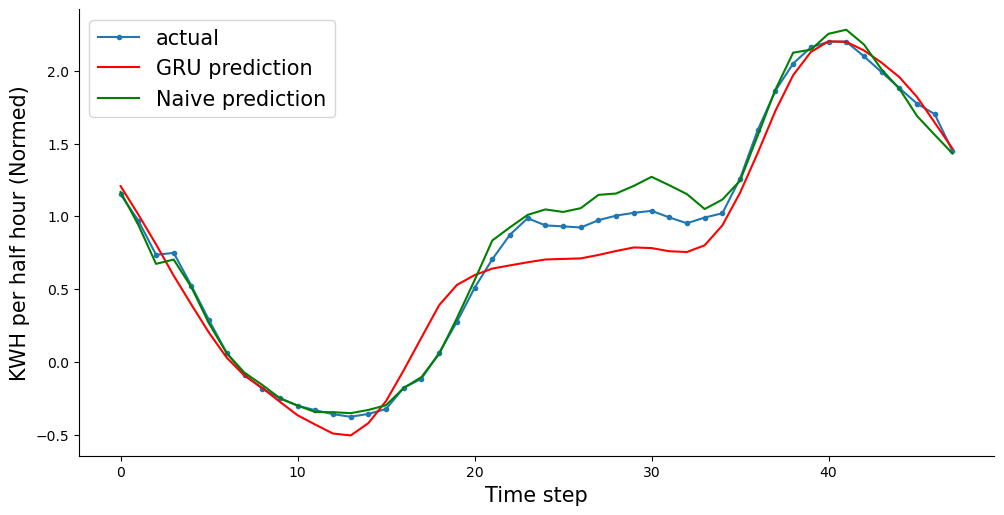

<Figure size 640x480 with 0 Axes>

In [101]:
# Plot Naive prediction, GRU prediction and Actuals for first 24 hours of the test set (normed values)
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeDataNormed.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhatNormed[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecastNormed[train_size+val_size:train_size+val_size+OUT_STEPS].AggregateLoad, 'g', label="Naive prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour (Normed)', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();
plt.savefig('Test First Day Normed.png', format='png')

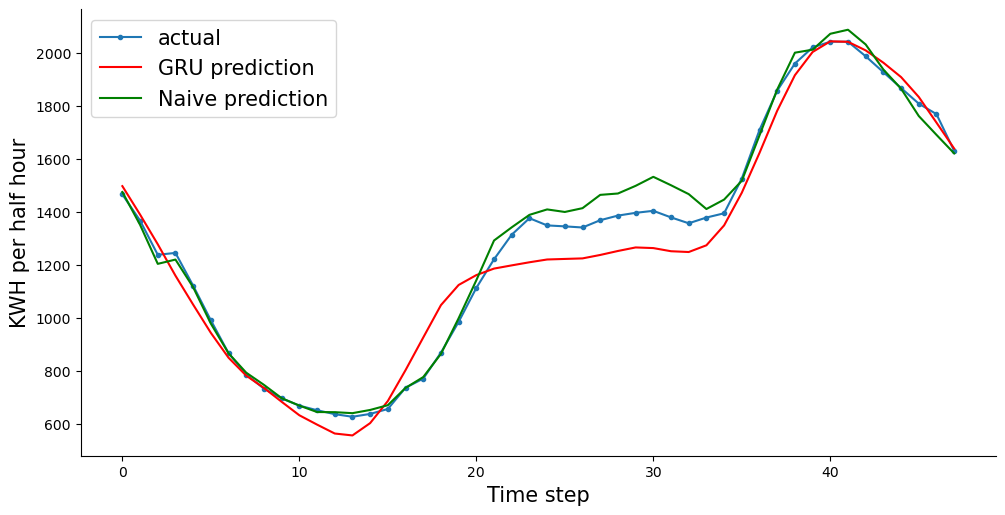

<Figure size 640x480 with 0 Axes>

In [102]:
len_prediction=[x for x in range(len(testYhat[0,:,-1]))]
plt.figure(figsize=(10,5))
# plt.plot(len_prediction, test_data[:OUT_STEPS].AggregateLoad, marker='.', label="actual")
plt.plot(len_prediction, mergeData.AggregateLoad[train_size+val_size:train_size+val_size+OUT_STEPS], marker='.', label="actual")
plt.plot(len_prediction, testYhat[0,:,-1], 'r', label="GRU prediction")
plt.plot(len_prediction, NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS], 'g', label="Naive prediction")
        
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('KWH per half hour', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()
plt.savefig('Test First Day.png', format='png')

## Aggregate results for Test period: Benchmark, GRU model and actuals

In [103]:
# 

# Estimate financial impact of improved forecast

## Load pricing data

Load day forward and real time wholesale electricity pricing data to help us estimate financial benefit of the best model.

In [104]:
import scipy.io

# Load the MATLAB file
mat_file = scipy.io.loadmat('/kaggle/input/pjm-and-miso-electricity-markets-price-data/DataJanMar2014_1632h.mat')
print(mat_file)

# Convert the MATLAB data to a Pandas dataframe
# df = pd.DataFrame(mat_file)

# Print the Pandas dataframe
# print(df)


{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Apr 10 20:20:16 2015', '__version__': '1.0', '__globals__': [], 'node_names_MISO': array([[array(['AMIL__CCG_5__AZ'], dtype='<U15')],
       [array(['ALTW__FAIR1'], dtype='<U11')],
       [array(['NSP__KEYCIT3'], dtype='<U12')],
       ...,
       [array(['EES__DOWCHEMECO'], dtype='<U15')],
       [array(['EES__DOWCHEMSUP'], dtype='<U15')],
       [array(['EES__ELILD__RLA'], dtype='<U15')]], dtype=object), 'node_names_PJM': array([[array(['242'], dtype='<U3')],
       [array(['243'], dtype='<U3')],
       [array(['244'], dtype='<U3')],
       ...,
       [array(['1186405573'], dtype='<U10')],
       [array(['1205137836'], dtype='<U10')],
       [array(['1205267539'], dtype='<U10')]], dtype=object), 'da_lmp_pjm': array([[39.90525462, 39.81044465, 39.26498528, ..., 35.1808865 ,
        36.24423625, 36.3827905 ],
       [39.56761293, 39.43701448, 38.80834009, ..., 35.96065802,
        36.90418365, 37.182257  ],
      

The average offer price for “balancing actions” – to align supply and demand – between the start of September and early January was £287 a MWh. Data from Elexon, which oversees the market, shows Rye House submitted the 20 highest winter bids – between £5,000 and £6,000 a MWh – for varying volumes of power on 12 December, setting new records
https://www.theguardian.com/business/2023/jan/29/gas-fired-plants-uk-lights-on-cost-profits-energy-crisis

In [105]:
# Area Under Curve
from scipy.integrate import simpson
from numpy import trapz

# The y values.  A numpy array is used here,
# but a python list could also be used.
# y = np.array([5, 20, 4, 18, 19, 18, 7, 4])
yhat = NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS]

print(NaiveForecast[train_size+val_size:train_size+val_size+OUT_STEPS])
print(yhat)

# Compute the area using the composite trapezoidal rule.
yhatArea = trapz(yhat, dx=5)
# print("yhat area =", yhatArea)

# Compute the area using the composite Simpson's rule.
yhatArea = simpson(yhat, dx=5)
# print("yhat area =", yhatArea)

yActual = mergeData.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS]

# Compute the area using the composite trapezoidal rule.
yActualArea = trapz(yActual, dx=5)
print("yActualArea trapz =", yActualArea)

# Compute the area using the composite Simpson's rule.
yActualArea = simpson(yActual, dx=5)
print("yActualArea simpson =", yActualArea)

# Calculate the area difference between the two curves...
AreaDifference = yhatArea - yActualArea
print("AreaDifference =", AreaDifference)

# calculate price at £287 a MWh
cost = (AreaDifference / 1000) * 287
print("cost for 1 day for 5k homes =", cost)


35451    1474.518305
35452    1350.730117
35453    1203.409426
35454    1219.604737
35455    1115.181730
35456     977.838783
35457     865.845835
35458     792.610886
35459     746.734939
35460     696.546990
35461     668.534041
35462     644.263093
35463     643.717145
35464     639.973197
35465     652.121247
35466     670.074299
35467     735.289352
35468     776.170402
35469     863.740454
35470     998.312505
35471    1141.607558
35472    1291.530661
35473    1341.272767
35474    1388.302871
35475    1408.838973
35476    1399.255079
35477    1413.571683
35478    1463.764287
35479    1468.893391
35480    1497.823495
35481    1531.852600
35482    1500.052705
35483    1466.560808
35484    1410.341914
35485    1445.993017
35486    1517.053121
35487    1688.238225
35488    1861.229328
35489    2000.305434
35490    2011.679537
35491    2071.646590
35492    2086.940642
35493    2031.299693
35494    1936.671745
35495    1864.426683
35496    1761.258625
35497    1690.206565
35498    1620

The population of England was 56,489,800 in 2021
24.9 million dwellings in England



In [106]:
# Scale up costs
cost = cost * (56000000/5000)
print("cost for 1 day for 5k homes =", cost)

cost for 1 day for 5k homes = 235842154.4737261


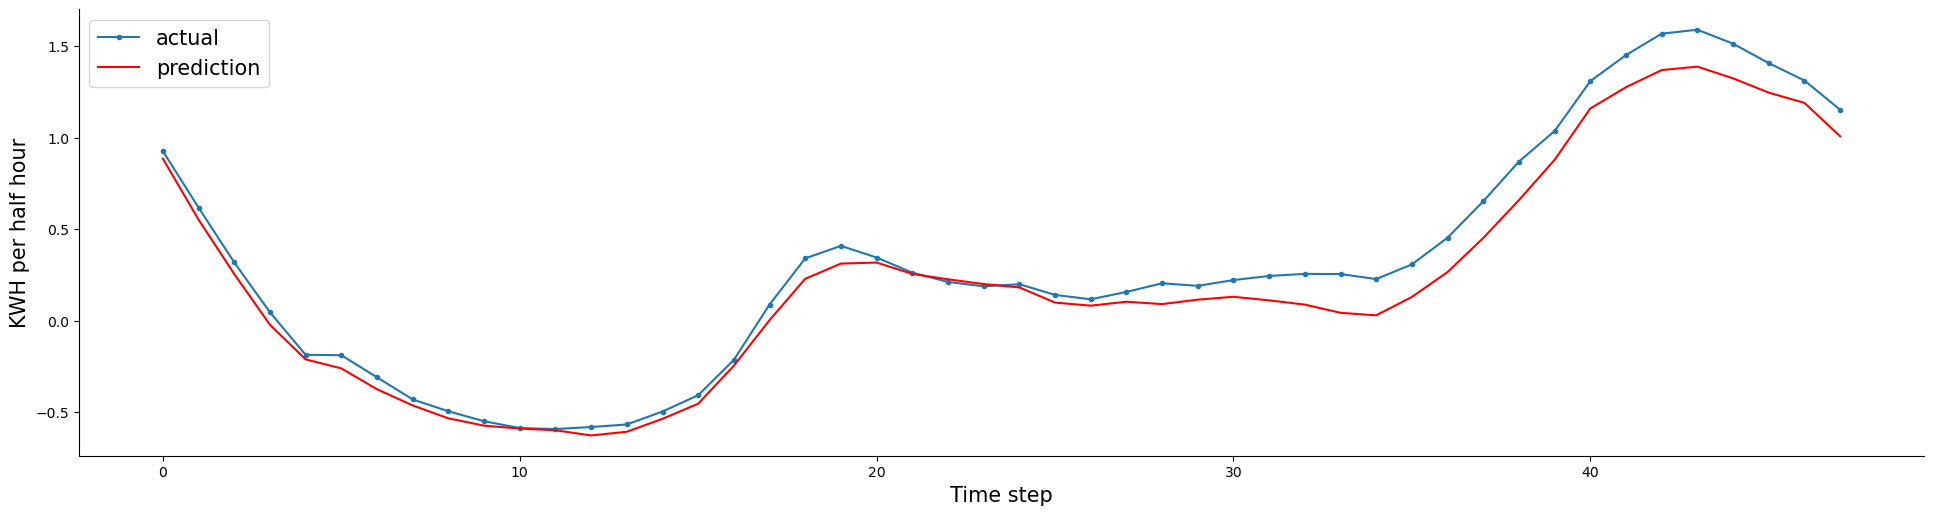

In [107]:
# visualize naive forecast and actuals for first day of the test dataset
mergeDataNormed = (mergeData - train_mean) / train_std
prediction_plot(mergeDataNormed.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS], NaiveForecastNormed.AggregateLoad[train_size+test_size:train_size+test_size+OUT_STEPS])

In [108]:
print(mergeDataNormed.AggregateLoad[train_size:train_size+val_size])
print(NaiveForecastNormed.AggregateLoad[train_size:train_size+val_size])


27573    0.635524
27574    0.675390
27575    0.835651
27576    0.828557
27577    0.775659
           ...   
35446    1.763720
35447    1.662769
35448    1.571899
35449    1.444844
35450    1.320255
Name: AggregateLoad, Length: 7878, dtype: float64
27573    0.838458
27574    0.878517
27575    0.892129
27576    0.831650
27577    0.788675
           ...   
35446    1.770586
35447    1.636878
35448    1.500072
35449    1.404624
35450    1.298011
Name: AggregateLoad, Length: 7878, dtype: float64
